In [37]:
import pandas as pd
from typing import Tuple, Optional

## Step 1: Load and clean tower data

In [38]:
GLOBAL_PATH="/home/jose/DATA_WEATHER_ORNL/data"

# Specify towers and variables of interest
towers_of_interest = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']
vars = ['TempC',
        'RelHum', 'AbsHum', 
        'WSpdMph', 'PkWSpdMph', 'VSSpdMph',
        'SolarRadWm2', 
        'BarPresMb',
        'Sigma', 'SigPhi',
        'WDir',
        'PrecipIn']


tower_dfs_15m_clean = []
for tower in towers_of_interest:

    df = pd.read_csv(f'{GLOBAL_PATH}/{tower}_2017-2022_final-qc.csv', 
                     header=0, skipfooter=1, na_values=[-999, '-999'], 
                     engine='python', parse_dates=True)
    
    df['timestampUTC'] = pd.to_datetime(df['timestampUTC'], format='%Y%m%d%H%M%S').dt.tz_localize('UTC')
    df = df.set_index('timestampUTC', drop=True)

    print(f"{tower}: {df.shape[0]} rows × {df.shape[1]} columns")  # <-- print dataset size

    tower_dfs_15m_clean.append(df)



TOWA: 210287 rows × 18 columns
TOWB: 210287 rows × 18 columns
TOWD: 210287 rows × 28 columns
TOWF: 210287 rows × 12 columns
TOWS: 210287 rows × 7 columns
TOWY: 210287 rows × 18 columns


In [39]:
tower_dfs_15m_clean

[                           TempC_015m  TempC_030m  RelHum_015m  AbsHum_015m  \
 timestampUTC                                                                  
 2017-01-01 05:00:00+00:00         3.6         3.6         97.4          6.0   
 2017-01-01 05:15:00+00:00         3.6         3.6         97.3          6.0   
 2017-01-01 05:30:00+00:00         3.6         3.7         97.4          6.0   
 2017-01-01 05:45:00+00:00         3.7         3.7         97.4          6.0   
 2017-01-01 06:00:00+00:00         3.8         3.8         97.3          6.0   
 ...                               ...         ...          ...          ...   
 2023-01-01 03:30:00+00:00        10.1        12.3         98.5          9.2   
 2023-01-01 03:45:00+00:00        10.2        11.8         98.6          9.3   
 2023-01-01 04:00:00+00:00        10.4        11.7         98.6          9.4   
 2023-01-01 04:15:00+00:00        10.2        11.7         98.6          9.3   
 2023-01-01 04:30:00+00:00        10.0  

## Step 2: Detect extreme events per tower

In [40]:
# Event thresholds and required minimum duration (hours)
EVENT_SPECS = {
    # Event name: (required variables, condition function, minimum duration in hours)
    "E1_TempMoistHaz": (
        ["TempC", "AbsHum"],
        lambda df, col: (df[col["TempC"]] > 24.0) & (df[col["AbsHum"]] > 20.0),
        2.0
    ),
    "E2_WindChill": (
        ["TempC", "PkWSpdMph"],
        lambda df, col: (df[col["TempC"]] <= 4.8) & (df[col["PkWSpdMph"]] >= 3.0),
        2.0
    ),
    "E3_LowTemp_lt0":   (["TempC"], lambda df, col: df[col["TempC"]] < 0.0,   2.0),
    "E3_LowTemp_lt-5":  (["TempC"], lambda df, col: df[col["TempC"]] < -5.0,  2.0),
    "E3_LowTemp_lt-10": (["TempC"], lambda df, col: df[col["TempC"]] < -10.0, 2.0),

    "E4_HighWind_Peak_gt25": (["PkWSpdMph"], lambda df, col: df[col["PkWSpdMph"]] > 25.0, 1.0),

    "E5_LowWind_lt2":   (["PkWSpdMph"], lambda df, col: df[col["PkWSpdMph"]] < 2.0,  3.0),
    "E5_LowWind_lt1":   (["PkWSpdMph"], lambda df, col: df[col["PkWSpdMph"]] < 1.0,  3.0),
    "E5_LowWind_lt0_5": (["PkWSpdMph"], lambda df, col: df[col["PkWSpdMph"]] < 0.5, 3.0),
}

# Sensor columns used for each tower 
colmap_per_tower = {
    "TOWA": {"TempC":"TempC_030m","AbsHum":"AbsHum_015m","PkWSpdMph":"PkWSpdMph_030m"},
    "TOWB": {"TempC":"TempC_030m","AbsHum":None,          "PkWSpdMph":"PkWSpdMph_030m"},
    "TOWD": {"TempC":"TempC_035m","AbsHum":"AbsHum_015m","PkWSpdMph":"PkWSpdMph_035m"},
    "TOWF": {"TempC":"TempC_010m","AbsHum":"AbsHum_010m","PkWSpdMph":"PkWSpdMph_010m"},
    "TOWS": {"TempC":"TempC_025m","AbsHum":None,          "PkWSpdMph":"PkWSpdMph_025m"},
    "TOWY": {"TempC":"TempC_033m","AbsHum":None,          "PkWSpdMph":"PkWSpdMph_033m"},
}



In [41]:
# infer the median step size of the time index (minutes)
def infer_step_minutes(index: pd.DatetimeIndex, fallback=15.0) -> float:
    if len(index) < 2:
        return float(fallback)
    diffs = pd.Series(index).diff().dropna().dt.total_seconds() / 60.0
    return float(diffs.median()) if not diffs.empty else float(fallback)
    

# convert a boolean time series into continuous event segments
def boolean_runs_to_segments(mask: pd.Series, min_duration_min: float) -> list:
    """
    MODIFIED: Keep ALL events but add duration metadata
    """
    if mask.empty:
        return []
    # Identify transition points (True blocks)
    m = mask.astype(bool).copy()
    change = m.ne(m.shift(1, fill_value=False))
    starts = m & change
    ends   = (~m) & change
    start_times = list(mask.index[starts])
    end_times   = list(mask.index[ends])

    # If the series ends with True, close the last block at the end
    if len(start_times) > len(end_times):
        end_times.append(mask.index[-1])

    segs = []
    for st, et in zip(start_times, end_times):
        dur = (et - st).total_seconds()/60.0
        meets_min_duration = dur >= min_duration_min
        # Keep ALL events, but add metadata about duration threshold
        segs.append((st, et, dur, meets_min_duration))
    return segs

# Main function: classify events for one tower 
def classify_events_for_tower(df: pd.DataFrame, tower_name: str) -> pd.DataFrame:
    """
    MODIFIED: Keep all events but record if they meet minimum duration
    """
    cmap = colmap_per_tower.get(tower_name, {})
    idx = pd.to_datetime(df.index)
    step_min = infer_step_minutes(idx, fallback=15.0)

    out = []
    for ev, (needed_keys, cond_fn, min_hours) in EVENT_SPECS.items():
        # Skip events if the tower is missing required variables
        ok = True
        for k in needed_keys:
            colname = cmap.get(k)
            if (colname is None) or (colname not in df.columns):
                ok = False
                break
        if not ok:
            continue

        # Evaluate the condition; any row with NaN is treated as False
        sub = df[[cmap[k] for k in needed_keys]].copy()
        mask = cond_fn(df, cmap) & (~sub.isna().any(axis=1))
        mask = pd.Series(mask.values, index=idx)

        # Convert True blocks to event segments (keep ALL events)
        min_duration_min = min_hours * 60.0
        segs = boolean_runs_to_segments(mask, min_duration_min=min_duration_min)
        
        for st, et, dur, meets_min_duration in segs:
            out.append({
                "tower": tower_name,
                "event": ev,
                "start": st,
                "end": et,
                "duration_minutes": float(dur),
                "meets_min_duration": meets_min_duration,
                "min_duration_required_min": min_duration_min
            })

    return pd.DataFrame(out)

# Batch processing across all towers 
def classify_all_towers(tower_dfs_15m_clean: list, towers_of_interest: list) -> pd.DataFrame:
    """
    Input: list of tower DataFrames (same order as towers_of_interest)
    Output: combined DataFrame with event segments across towers
    """
    all_rows = []
    for tower, df in zip(towers_of_interest, tower_dfs_15m_clean):
        seg = classify_events_for_tower(df, tower)
        all_rows.append(seg)
    if not all_rows:
        return pd.DataFrame(columns=["tower","event","start","end","duration_minutes","meets_min_duration","min_duration_required_min"])
    out = pd.concat(all_rows, ignore_index=True).sort_values(["tower","event","start"])
    return out

# NEW FUNCTION: Create fully labeled dataset with event flags for every timestamp
def create_fully_labeled_dataset(tower_dfs_15m_clean: list, towers_of_interest: list) -> pd.DataFrame:
    """
    Create a DataFrame where EVERY original data point is labeled with event information
    Returns: Combined DataFrame with all original data + event labels
    Structure: TOWER | TIMESTAMP | Original Variables | Event Flags
    """
    
    all_labeled_dfs = []
    
    for tower, df in zip(towers_of_interest, tower_dfs_15m_clean):
        print(f"Labeling data for {tower}...")
        
        # Create a copy of the original data
        labeled_df = df.copy()
        labeled_df['tower'] = tower
        labeled_df['timestamp'] = labeled_df.index  # Explicit timestamp column
        
        # Get events for this specific tower
        tower_events = classify_events_for_tower(df, tower)
        
        # Initialize ALL event columns (even if no events detected)
        all_event_types = list(EVENT_SPECS.keys())
        for event in all_event_types:
            labeled_df[f'event_{event}'] = False
            labeled_df[f'event_{event}_duration_min'] = 0.0
            labeled_df[f'event_{event}_meets_duration'] = False
        
        # Label each timestamp with event information
        if not tower_events.empty:
            for _, event_row in tower_events.iterrows():
                event_name = event_row['event']
                start_time = event_row['start']
                end_time = event_row['end']
                duration = event_row['duration_minutes']
                meets_duration = event_row['meets_min_duration']
                
                # Mark timestamps within this event period
                event_mask = (labeled_df.index >= start_time) & (labeled_df.index <= end_time)
                labeled_df.loc[event_mask, f'event_{event_name}'] = True
                labeled_df.loc[event_mask, f'event_{event_name}_duration_min'] = duration
                labeled_df.loc[event_mask, f'event_{event_name}_meets_duration'] = meets_duration
        
        # Create summary columns
        def count_active_events(row):
            count = 0
            for event in all_event_types:
                if row[f'event_{event}']:
                    count += 1
            return count
        
        def get_active_event_list(row):
            active_events = []
            for event in all_event_types:
                if row[f'event_{event}']:
                    meets_dur = row[f'event_{event}_meets_duration']
                    status = event if meets_dur else f"{event}*"  # * for short events
                    active_events.append(status)
            return ','.join(active_events) if active_events else 'none'
        
        def get_event_durations(row):
            durations = []
            for event in all_event_types:
                if row[f'event_{event}']:
                    dur = row[f'event_{event}_duration_min']
                    durations.append(f"{event}:{dur:.1f}min")
            return ','.join(durations) if durations else 'none'
        
        labeled_df['event_count'] = labeled_df.apply(count_active_events, axis=1)
        labeled_df['active_events'] = labeled_df.apply(get_active_event_list, axis=1)
        labeled_df['event_durations'] = labeled_df.apply(get_event_durations, axis=1)
        labeled_df['has_any_event'] = labeled_df['active_events'] != 'none'
        
        all_labeled_dfs.append(labeled_df)
    
    # Combine all towers into one big labeled dataset
    if all_labeled_dfs:
        full_labeled_dataset = pd.concat(all_labeled_dfs, axis=0)
        full_labeled_dataset = full_labeled_dataset.sort_values(['timestamp', 'tower'])
        return full_labeled_dataset
    else:
        return pd.DataFrame()

# Run the complete pipeline
print("Step 1: Loading and preprocessing data...")
print(f"Loaded {len(tower_dfs_15m_clean)} towers")

print("\nStep 2: Creating fully labeled dataset...")
labeled_data = create_fully_labeled_dataset(tower_dfs_15m_clean, towers_of_interest)

print(f"Labeled dataset shape: {labeled_data.shape}")
print(f"Total data points: {len(labeled_data):,}")
print(f"Towers: {labeled_data['tower'].unique().tolist()}")

# Analysis of labeling results
print("\n=== LABELING RESULTS ===")
print(f"Total timestamps: {len(labeled_data):,}")
print(f"Timestamps with ANY event: {labeled_data['has_any_event'].sum():,} ({labeled_data['has_any_event'].mean()*100:.2f}%)")

# Event frequency analysis
event_cols = [col for col in labeled_data.columns if col.startswith('event_E') and not any(x in col for x in ['duration', 'meets'])]
print(f"\nEvent frequencies:")
for event_col in event_cols:
    event_name = event_col.replace('event_', '')
    count = labeled_data[event_col].sum()
    if count > 0:
        percentage = (count / len(labeled_data)) * 100
        print(f"  {event_name}: {count:,} timestamps ({percentage:.2f}%)")

# Show sample of the final structure
print("\n=== SAMPLE OF LABELED DATA ===")
sample_columns = ['tower', 'timestamp', 'event_count', 'active_events', 'has_any_event']
event_sample_cols = [col for col in labeled_data.columns if col.startswith('event_E') and not any(x in col for x in ['duration', 'meets'])]
sample_columns.extend(event_sample_cols[:3])  # Show first 3 event types

print(labeled_data[sample_columns].head(15))

# Save the fully labeled dataset
print("\nStep 3: Saving results...")
labeled_data.to_csv("fully_labeled_weather_data_with_events.csv", index=False)

# Create a simplified version for quick analysis

print("\n=== FILES SAVED ===")
print("1. fully_labeled_weather_data_with_events.csv - Complete dataset with all original variables + event labels")

print(f"\nDataset structure: {labeled_data.shape[1]} columns, {labeled_data.shape[0]:,} rows")
print("Each row represents: TOWER | TIMESTAMP | WEATHER VARIABLES | EVENT FLAGS")

Step 1: Loading and preprocessing data...
Loaded 6 towers

Step 2: Creating fully labeled dataset...
Labeling data for TOWA...
Labeling data for TOWB...
Labeling data for TOWD...
Labeling data for TOWF...
Labeling data for TOWS...
Labeling data for TOWY...
Labeled dataset shape: (1261722, 96)
Total data points: 1,261,722
Towers: ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']

=== LABELING RESULTS ===
Total timestamps: 1,261,722
Timestamps with ANY event: 301,075 (23.86%)

Event frequencies:
  E1_TempMoistHaz: 5,979 timestamps (0.47%)
  E2_WindChill: 153,081 timestamps (12.13%)
  E3_LowTemp_lt0: 61,463 timestamps (4.87%)
  E3_LowTemp_lt-5: 14,274 timestamps (1.13%)
  E3_LowTemp_lt-10: 2,767 timestamps (0.22%)
  E4_HighWind_Peak_gt25: 28,607 timestamps (2.27%)
  E5_LowWind_lt2: 114,583 timestamps (9.08%)
  E5_LowWind_lt1: 28,143 timestamps (2.23%)
  E5_LowWind_lt0_5: 9,394 timestamps (0.74%)

=== SAMPLE OF LABELED DATA ===
                          tower                 timestamp  even

## Step 3: Union events across towers


In [42]:
# Read the CSV file
df = pd.read_csv("fully_labeled_weather_data_with_events.csv")

# 2️⃣ Move 'tower' and 'timestamp' to the first two columns
cols = df.columns.tolist()
priority_cols = ['tower', 'timestamp']
remaining_cols = [c for c in cols if c not in priority_cols]
df = df[priority_cols + remaining_cols]

# Drop columns ending with '_min' or '_meets_duration'
df = df.loc[:, ~df.columns.str.endswith(('_min', '_meets_duration'))]

#remove these columns
df = df.drop(columns=['event_count','active_events','event_durations', 'has_any_event'])


# Check the first few rows
df.head(20)


,tower,timestamp,TempC_015m,TempC_030m,RelHum_015m,AbsHum_015m,WSpdMph_015m,WSpdMph_030m,PkWSpdMph_015m,PkWSpdMph_030m,...,Sigma_025m,SigPhi_025m,WDir_025m,TempC_033m,WSpdMph_033m,PkWSpdMph_033m,VSSpdMph_033m,Sigma_033m,SigPhi_033m,WDir_033m
0,TOWA,2017-01-01 05:00:00+00:00,3.600000,3.6,97.4,6.0,2.2,4.4,5.9,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TOWB,2017-01-01 05:00:00+00:00,3.900000,3.8,99.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TOWD,2017-01-01 05:00:00+00:00,3.900000,NaN,97.2,6.1,2.2,NaN,5.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TOWF,2017-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TOWS,2017-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.9,8.3,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TOWY,2017-01-01 05:00:00+00:00,4.166666,NaN,95.7,NaN,7.6,NaN,13.1,NaN,...,NaN,NaN,NaN,3.777777,8.8,15.3,-0.182,16.7,11.2,274.0
6,TOWA,2017-01-01 05:15:00+00:00,3.600000,3.6,97.3,6.0,2.4,4.7,6.7,7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TOWB,2017-01-01 05:15:00+00:00,3.800000,3.7,99.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TOWD,2017-01-01 05:15:00+00:00,3.900000,NaN,97.5,6.1,2.1,NaN,6.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TOWF,2017-01-01 05:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EVENT SUMMARY:

In [43]:



import pandas as pd

# List all boolean event columns
event_cols = [
    'event_E1_TempMoistHaz',
    'event_E2_WindChill',
    'event_E3_LowTemp_lt0',
    'event_E3_LowTemp_lt-5',
    'event_E3_LowTemp_lt-10',
    'event_E4_HighWind_Peak_gt25',
    'event_E5_LowWind_lt2',
    'event_E5_LowWind_lt1',
    'event_E5_LowWind_lt0_5'
]

# Ensure the columns are boolean
df[event_cols] = df[event_cols].astype(bool)

# Count how many events are True per row
df["true_event_count"] = df[event_cols].sum(axis=1)

# Filter: rows where more than 2 events are True simultaneously (per tower)
multiple_events_df = df[df["true_event_count"] > 2]

# Optional: group by tower if you want to see which towers are affected
tower_event_summary = multiple_events_df.groupby("tower")["true_event_count"].count().reset_index()

print("✅ Rows with more than two active events:")
print(multiple_events_df[["tower", "timestamp", "true_event_count"]])

print("\n📊 Summary of towers with >2 events:")
print(tower_event_summary)


✅ Rows with more than two active events:
        tower                  timestamp  true_event_count
499      TOWB  2017-01-02 01:45:00+00:00                 3
505      TOWB  2017-01-02 02:00:00+00:00                 3
511      TOWB  2017-01-02 02:15:00+00:00                 3
715      TOWB  2017-01-02 10:45:00+00:00                 3
716      TOWD  2017-01-02 10:45:00+00:00                 3
...       ...                        ...               ...
1260197  TOWY  2022-12-29 13:00:00+00:00                 3
1260203  TOWY  2022-12-29 13:15:00+00:00                 3
1261639  TOWB  2023-01-01 01:15:00+00:00                 3
1261645  TOWB  2023-01-01 01:30:00+00:00                 3
1261651  TOWB  2023-01-01 01:45:00+00:00                 3

[25320 rows x 3 columns]

📊 Summary of towers with >2 events:
  tower  true_event_count
0  TOWA              3514
1  TOWB              4937
2  TOWD              6921
3  TOWF              2720
4  TOWS              3319
5  TOWY              3909


In [44]:
# Check all unique tower types
print("Unique tower types:", df['tower'].unique())

# Split into separate DataFrames per tower
tower_dfs = {tower: df[df['tower'] == tower].copy() for tower in df['tower'].unique()}

# Example: Access one tower's dataset
print("\nExample – TOWA DataFrame:")
print(tower_dfs['TOWA'].head())

Unique tower types: ['TOWA' 'TOWB' 'TOWD' 'TOWF' 'TOWS' 'TOWY']

Example – TOWA DataFrame:
   tower                  timestamp  TempC_015m  TempC_030m  RelHum_015m  \
0   TOWA  2017-01-01 05:00:00+00:00         3.6         3.6         97.4   
6   TOWA  2017-01-01 05:15:00+00:00         3.6         3.6         97.3   
12  TOWA  2017-01-01 05:30:00+00:00         3.6         3.7         97.4   
18  TOWA  2017-01-01 05:45:00+00:00         3.7         3.7         97.4   
24  TOWA  2017-01-01 06:00:00+00:00         3.8         3.8         97.3   

    AbsHum_015m  WSpdMph_015m  WSpdMph_030m  PkWSpdMph_015m  PkWSpdMph_030m  \
0           6.0           2.2           4.4             5.9            10.2   
6           6.0           2.4           4.7             6.7             7.7   
12          6.0           2.8           4.3             6.0             6.8   
18          6.0           2.5           4.2             5.1             6.8   
24          6.0           2.2           4.0             4

In [45]:
import pandas as pd
import numpy as np

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Compute % of nulls per column and tower
null_percentage = df.groupby('tower').apply(lambda x: x.isnull().mean() * 100).round(2)

# Define non-overlapping ranges: 0–10%, 10–20%, ..., 90–100%
bins = np.arange(0, 110, 10)  # 0,10,20,...,100
range_labels = [f"{bins[i]}–{bins[i+1]}% nulls" for i in range(len(bins)-1)]

# Store results in dictionary
ranges = {label: [] for label in range_labels}

for tower in null_percentage.index:
    tower_data = null_percentage.loc[tower]
    for i in range(len(bins)-1):
        low, high = bins[i], bins[i+1]
        cols = list(tower_data[(tower_data >= low) & (tower_data < high)].index)
        ranges[range_labels[i]].append((tower, cols))

# Print summary
for category, values in ranges.items():
    print(f"\n===== {category} =====")
    for tower, cols in values:
        if len(cols) > 0:
            print(f"Tower {tower}: {len(cols)} columns → {cols}")



===== 0–10% nulls =====
Tower TOWA: 29 columns → ['tower', 'timestamp', 'TempC_015m', 'TempC_030m', 'RelHum_015m', 'AbsHum_015m', 'WSpdMph_015m', 'PkWSpdMph_015m', 'PkWSpdMph_030m', 'VSSpdMph_015m', 'VSSpdMph_030m', 'BarPresMb_015m', 'Sigma_015m', 'Sigma_030m', 'SigPhi_015m', 'SigPhi_030m', 'WDir_015m', 'WDir_030m', 'PrecipIn_015m', 'event_E1_TempMoistHaz', 'event_E2_WindChill', 'event_E3_LowTemp_lt0', 'event_E3_LowTemp_lt-5', 'event_E3_LowTemp_lt-10', 'event_E4_HighWind_Peak_gt25', 'event_E5_LowWind_lt2', 'event_E5_LowWind_lt1', 'event_E5_LowWind_lt0_5', 'true_event_count']
Tower TOWB: 13 columns → ['tower', 'timestamp', 'BarPresMb_015m', 'event_E1_TempMoistHaz', 'event_E2_WindChill', 'event_E3_LowTemp_lt0', 'event_E3_LowTemp_lt-5', 'event_E3_LowTemp_lt-10', 'event_E4_HighWind_Peak_gt25', 'event_E5_LowWind_lt2', 'event_E5_LowWind_lt1', 'event_E5_LowWind_lt0_5', 'true_event_count']
Tower TOWD: 35 columns → ['tower', 'timestamp', 'TempC_015m', 'RelHum_015m', 'AbsHum_015m', 'BarPresMb_0

/tmp/ipykernel_883071/3669835264.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_percentage = df.groupby('tower').apply(lambda x: x.isnull().mean() * 100).round(2)


In [46]:
def filter_dfs_below_threshold(df, ranges, threshold=100):
    """
    Filter all towers, keeping columns whose null % is below a threshold.
    Always keeps 'tower', 'timestamp' and 'true_event_count'.
    """
    filtered_dfs = {}
    
    # Find all ranges below threshold
    selected_ranges = [r for r in ranges.keys() if int(r.split("–")[1].replace("% nulls","")) <= threshold]
    
    for tower in df['tower'].unique():
        cols_to_keep = ['tower', 'timestamp']  # <-- keep true_event_count
        
        # Collect columns from all selected ranges
        for r in selected_ranges:
            for t, cols in ranges[r]:
                if t == tower:
                    cols_to_keep.extend(cols)
        
        # Remove duplicates (some columns may appear in multiple ranges)
        cols_to_keep = list(dict.fromkeys(cols_to_keep))
        
        # Guard: keep only columns that actually exist in the dataframe
        cols_to_keep = [c for c in cols_to_keep if c in df.columns]
        
        filtered_dfs[tower] = df[df['tower'] == tower][cols_to_keep].copy()
        filtered_dfs[tower] = filtered_dfs[tower].drop("true_event_count", axis=1)
    
    return filtered_dfs

filtered_dfs = filter_dfs_below_threshold(df, ranges, threshold=100)


In [51]:
{tower: list(df.columns) for tower, df in filtered_dfs.items()}

{'TOWA': ['tower',
  'timestamp',
  'TempC_015m',
  'TempC_030m',
  'RelHum_015m',
  'AbsHum_015m',
  'WSpdMph_015m',
  'PkWSpdMph_015m',
  'PkWSpdMph_030m',
  'VSSpdMph_015m',
  'VSSpdMph_030m',
  'BarPresMb_015m',
  'Sigma_015m',
  'Sigma_030m',
  'SigPhi_015m',
  'SigPhi_030m',
  'WDir_015m',
  'WDir_030m',
  'PrecipIn_015m',
  'event_E1_TempMoistHaz',
  'event_E2_WindChill',
  'event_E3_LowTemp_lt0',
  'event_E3_LowTemp_lt-5',
  'event_E3_LowTemp_lt-10',
  'event_E4_HighWind_Peak_gt25',
  'event_E5_LowWind_lt2',
  'event_E5_LowWind_lt1',
  'event_E5_LowWind_lt0_5',
  'WSpdMph_030m'],
 'TOWB': ['tower',
  'timestamp',
  'BarPresMb_015m',
  'event_E1_TempMoistHaz',
  'event_E2_WindChill',
  'event_E3_LowTemp_lt0',
  'event_E3_LowTemp_lt-5',
  'event_E3_LowTemp_lt-10',
  'event_E4_HighWind_Peak_gt25',
  'event_E5_LowWind_lt2',
  'event_E5_LowWind_lt1',
  'event_E5_LowWind_lt0_5',
  'TempC_015m',
  'TempC_030m',
  'WSpdMph_015m',
  'WSpdMph_030m',
  'PkWSpdMph_015m',
  'PkWSpdMph_030m'

In [56]:
# Temporarily disable truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # No width limit
pd.set_option('display.max_colwidth', None) # Full column names


In [57]:
filtered_dfs['TOWA']

,tower,timestamp,TempC_015m,TempC_030m,RelHum_015m,AbsHum_015m,WSpdMph_015m,PkWSpdMph_015m,PkWSpdMph_030m,VSSpdMph_015m,VSSpdMph_030m,BarPresMb_015m,Sigma_015m,Sigma_030m,SigPhi_015m,SigPhi_030m,WDir_015m,WDir_030m,PrecipIn_015m,event_E1_TempMoistHaz,event_E2_WindChill,event_E3_LowTemp_lt0,event_E3_LowTemp_lt-5,event_E3_LowTemp_lt-10,event_E4_HighWind_Peak_gt25,event_E5_LowWind_lt2,event_E5_LowWind_lt1,event_E5_LowWind_lt0_5,WSpdMph_030m
0,TOWA,2017-01-01 05:00:00+00:00,3.6,3.6,97.4,6.0,2.2,5.9,10.2,0.0,-0.100000,985.3,26.5,15.5,18.9,12.6,268.0,274.0,0.015748,False,True,False,False,False,False,False,False,False,4.4
6,TOWA,2017-01-01 05:15:00+00:00,3.6,3.6,97.3,6.0,2.4,6.7,7.7,0.0,-0.100000,985.3,19.3,13.9,14.3,9.8,252.0,264.0,0.011811,False,True,False,False,False,False,False,False,False,4.7
12,TOWA,2017-01-01 05:30:00+00:00,3.6,3.7,97.4,6.0,2.8,6.0,6.8,-0.2,0.000064,985.2,25.3,15.0,13.6,11.0,255.0,260.0,0.011811,False,True,False,False,False,False,False,False,False,4.3
18,TOWA,2017-01-01 05:45:00+00:00,3.7,3.7,97.4,6.0,2.5,5.1,6.8,-0.2,-0.100000,985.0,29.4,16.6,14.4,8.3,268.0,263.0,0.007874,False,True,False,False,False,False,False,False,False,4.2
24,TOWA,2017-01-01 06:00:00+00:00,3.8,3.8,97.3,6.0,2.2,4.2,6.3,0.0,0.100000,985.1,25.0,13.1,14.9,10.8,268.0,274.0,0.007874,False,True,False,False,False,False,False,False,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261692,TOWA,2023-01-01 03:30:00+00:00,10.1,12.3,98.5,9.2,0.4,NaN,NaN,0.0,NaN,984.4,78.6,11.0,12.9,3.4,120.7,248.9,0.000000,False,False,False,False,False,False,False,False,False,2.6
1261698,TOWA,2023-01-01 03:45:00+00:00,10.2,11.8,98.6,9.3,0.2,NaN,NaN,0.0,NaN,984.4,66.5,15.0,5.7,3.8,273.6,263.7,0.000000,False,False,False,False,False,False,False,False,False,2.5
1261704,TOWA,2023-01-01 04:00:00+00:00,10.4,11.7,98.6,9.4,0.7,NaN,NaN,0.0,NaN,984.5,45.9,15.7,12.4,4.8,253.0,259.9,0.000000,False,False,False,False,False,False,False,False,False,3.1
1261710,TOWA,2023-01-01 04:15:00+00:00,10.2,11.7,98.6,9.3,0.4,NaN,NaN,0.0,NaN,984.5,91.1,12.3,11.0,4.2,294.1,268.0,0.000000,False,False,False,False,False,False,False,False,False,2.9


# VIZULIZATION!

In [ ]:


from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ensure this exists
out_dir = Path("/home/jose/DATA_WEATHER_ORNL/viz_maps")
out_dir.mkdir(parents=True, exist_ok=True)

# Sanity check: filtered_dfs must be a dict of DataFrames keyed by tower name
print("Towers to visualize:", list(filtered_dfs.keys()))



def make_viz_map_for_tower(tower_df: pd.DataFrame, tower_name: str, out_dir: Path, null_display_top=40):
    """Create numeric × event heatmap for one tower and save output."""
    if tower_df is None or tower_df.empty:
        print(f"No data for {tower_name}")
        return

    df = tower_df.copy()
    # ensure timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    else:
        df.index = pd.to_datetime(df.index)
        df['timestamp'] = df.index

    # identify event columns and numeric sensor columns
    event_cols = [c for c in df.columns if str(c).startswith('event_')]
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # exclude boolean event columns that may be numeric
    numeric_cols = [c for c in numeric_cols if c not in event_cols]

    # numeric × event correlation (convert booleans to ints)
    if not numeric_cols or not event_cols:
        print(f"Skipping heatmap for {tower_name}: insufficient numeric or event columns")
        return

    combined = df[numeric_cols + event_cols].copy()
    for e in event_cols:
        # treat missing event flags as False
        combined[e] = combined[e].fillna(False).astype(int)

    corr_num_event = combined.corr().loc[numeric_cols, event_cols]

    if corr_num_event is None or corr_num_event.empty:
        print(f"No numeric × event correlations for {tower_name}")
        return

    sns.set(style="white")
    plt.figure(figsize=(8, max(4, 0.25 * len(numeric_cols))))
    sns.heatmap(corr_num_event.abs(), cmap='vlag', center=0, annot=False, cbar_kws={'label': '|Pearson r|'})
    plt.title(f"{tower_name} — numeric ↔ event |corr|")
    plt.tight_layout()
    out_path = out_dir / f"{tower_name}_numeric_event_heatmap.png"
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"Saved heatmap for {tower_name}: {out_path}")


# Option B — all towers (recommended)
for tower_name, tower_df in tqdm(filtered_dfs.items(), desc="Making viz maps"):
    make_viz_map_for_tower(tower_df, tower_name, out_dir)


/home/jose/.conda/envs/ml_env2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Towers to visualize: ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']


Making viz maps:  17%|█▋        | 1/6 [00:00<00:02,  1.99it/s]

Saved heatmap for TOWA: /home/jose/DATA_WEATHER_ORNL/viz_maps/TOWA_numeric_event_heatmap.png


Making viz maps:  33%|███▎      | 2/6 [00:00<00:01,  2.20it/s]

Saved heatmap for TOWB: /home/jose/DATA_WEATHER_ORNL/viz_maps/TOWB_numeric_event_heatmap.png


Making viz maps:  50%|█████     | 3/6 [00:01<00:01,  1.72it/s]

Saved heatmap for TOWD: /home/jose/DATA_WEATHER_ORNL/viz_maps/TOWD_numeric_event_heatmap.png


Making viz maps:  67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s]

Saved heatmap for TOWF: /home/jose/DATA_WEATHER_ORNL/viz_maps/TOWF_numeric_event_heatmap.png


Making viz maps:  83%|████████▎ | 5/6 [00:02<00:00,  2.50it/s]

Saved heatmap for TOWS: /home/jose/DATA_WEATHER_ORNL/viz_maps/TOWS_numeric_event_heatmap.png


Making viz maps: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

Saved heatmap for TOWY: /home/jose/DATA_WEATHER_ORNL/viz_maps/TOWY_numeric_event_heatmap.png


TOWB Dataset Info:
Shape: (210287, 28)
Date range: 2017-01-01 05:00:00+00:00 to 2023-01-01 04:30:00+00:00
Available months: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01']
  2022-08: 2,976 records
  2022-09: 2,880 records
  2022-10: 2,976 recor

/tmp/ipykernel_883071/1830725665.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['timestamp'].dt.to_period('M')


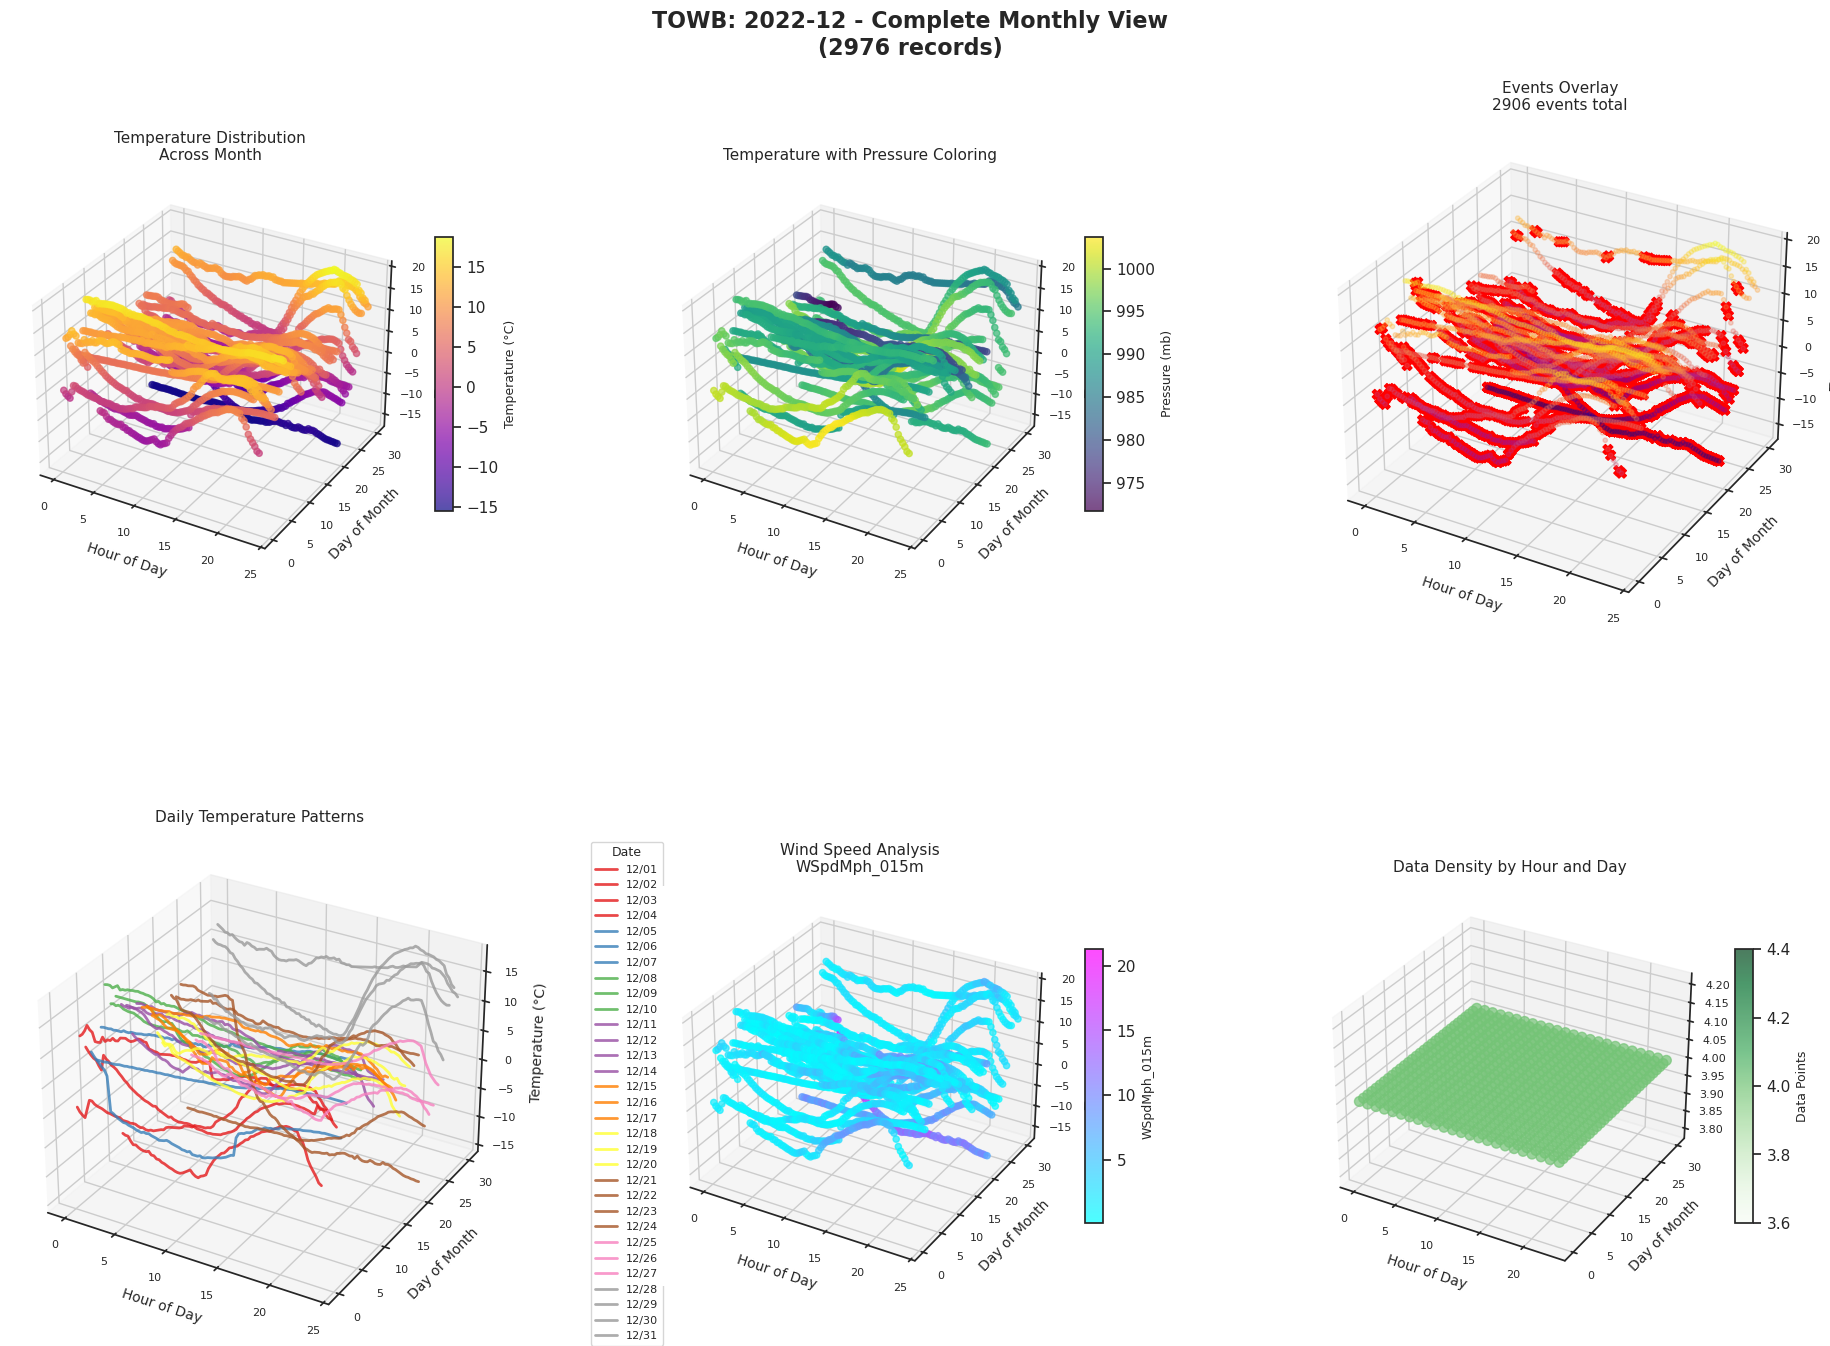

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta

# Get the TOWB dataset
df = filtered_dfs['TOWB'].copy()

print(f"TOWB Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Ensure timestamp is datetime and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Create month and week features
df['date'] = df['timestamp'].dt.date
df['year_month'] = df['timestamp'].dt.to_period('M')
df['week_of_month'] = (df['timestamp'].dt.day - 1) // 7 + 1
df['hour_of_day'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60
df['day_name'] = df['timestamp'].dt.day_name()

# Day order for consistent plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_numeric'] = df['day_name'].apply(lambda x: day_order.index(x) if x in day_order else -1)

# Get unique months in data and find one with sufficient data
unique_months = df['year_month'].unique()
print(f"Available months: {[str(m) for m in unique_months]}")

# Find a month with sufficient data (let's check the last 6 months)
recent_months = unique_months[-6:]  # Last 6 months
month_records = []

for month in recent_months:
    month_data = df[df['year_month'] == month]
    records = len(month_data)
    month_records.append((month, records))
    print(f"  {month}: {records:,} records")

# Choose the most recent month with reasonable data (at least 500 records)
analysis_month = None
for month, records in reversed(month_records):
    if records >= 500:  # At least ~5 days of data
        analysis_month = month
        break

if analysis_month is None:
    # If no month has 500 records, use the one with most records
    analysis_month = max(month_records, key=lambda x: x[1])[0]
    print(f"\nNo month has sufficient data, using {analysis_month} with {max(month_records, key=lambda x: x[1])[1]:,} records")
else:
    print(f"\nUsing {analysis_month} for analysis with {records:,} records")

month_df = df[df['year_month'] == analysis_month].copy()

print(f"\nAnalyzing month: {analysis_month}")
print(f"Records in month: {len(month_df)}")

# Get weeks in this month
weeks_in_month = sorted(month_df['week_of_month'].unique())
print(f"Weeks in month: {weeks_in_month}")

# Event columns for counting
event_columns = ['event_E1_TempMoistHaz', 'event_E2_WindChill', 'event_E3_LowTemp_lt0', 
                'event_E3_LowTemp_lt-5', 'event_E3_LowTemp_lt-10', 'event_E4_HighWind_Peak_gt25', 
                'event_E5_LowWind_lt2']

# Since we have limited data, let's create a single comprehensive 3D plot
fig = plt.figure(figsize=(20, 15))  # Increased figure size for better spacing
fig.suptitle(f'TOWB: {analysis_month} - Complete Monthly View\n({len(month_df)} records)', 
             fontsize=16, fontweight='bold')

# Convert dates to numeric for plotting
month_df['date_numeric'] = (month_df['timestamp'].dt.date - month_df['timestamp'].dt.date.min()).apply(lambda x: x.days)

# Standardized colorbar parameters
cbar_params = {
    'shrink': 0.5,
    'aspect': 15,
    'pad': 0.05  # Reduced padding for better spacing
}

# Standardized legend parameters
legend_params = {
    'bbox_to_anchor': (1.15, 1.0),  # Moved further right
    'loc': 'upper left',
    'fontsize': 8
}

# Plot 1: 3D Scatter of all data in the month
ax1 = fig.add_subplot(231, projection='3d')
scatter1 = ax1.scatter(month_df['hour_of_day'],
                      month_df['date_numeric'],
                      month_df['TempC_030m'],
                      c=month_df['TempC_030m'],
                      cmap='plasma',
                      s=20,
                      alpha=0.7)
ax1.set_xlabel('Hour of Day', fontsize=10)
ax1.set_ylabel('Day of Month', fontsize=10)
ax1.set_zlabel('Temperature (°C)', fontsize=10)
ax1.set_title('Temperature Distribution\nAcross Month', fontsize=11, pad=10)
ax1.tick_params(axis='both', which='major', labelsize=8)
cbar1 = plt.colorbar(scatter1, ax=ax1, **cbar_params)
cbar1.set_label('Temperature (°C)', fontsize=9)

# Plot 2: Pressure-colored scatter
ax2 = fig.add_subplot(232, projection='3d')
scatter2 = ax2.scatter(month_df['hour_of_day'],
                      month_df['date_numeric'],
                      month_df['TempC_030m'],
                      c=month_df['BarPresMb_015m'],
                      cmap='viridis',
                      s=20,
                      alpha=0.7)
ax2.set_xlabel('Hour of Day', fontsize=10)
ax2.set_ylabel('Day of Month', fontsize=10)
ax2.set_zlabel('Temperature (°C)', fontsize=10)
ax2.set_title('Temperature with Pressure Coloring', fontsize=11, pad=10)
ax2.tick_params(axis='both', which='major', labelsize=8)
cbar2 = plt.colorbar(scatter2, ax=ax2, **cbar_params)
cbar2.set_label('Pressure (mb)', fontsize=9)

# Plot 3: Events overlay
ax3 = fig.add_subplot(233, projection='3d')
# First plot all temperature points
scatter3 = ax3.scatter(month_df['hour_of_day'],
                      month_df['date_numeric'],
                      month_df['TempC_030m'],
                      c=month_df['TempC_030m'],
                      cmap='plasma',
                      s=10,
                      alpha=0.3)

# Then overlay events
n_events_total = 0
event_labels_added = set()
for event_col in event_columns:
    if event_col in month_df.columns:
        event_data = month_df[month_df[event_col] == True]
        n_events_total += len(event_data)
        if len(event_data) > 0:
            label = event_col.replace('event_', '') if event_col not in event_labels_added else ""
            event_labels_added.add(event_col)
            ax3.scatter(event_data['hour_of_day'],
                       event_data['date_numeric'],
                       event_data['TempC_030m'],
                       color='red',
                       marker='X',
                       s=50,
                       alpha=1.0,
                       label=label)

ax3.set_xlabel('Hour of Day', fontsize=10)
ax3.set_ylabel('Day of Month', fontsize=10)
ax3.set_zlabel('Temperature (°C)', fontsize=10)
ax3.set_title(f'Events Overlay\n{n_events_total} events total', fontsize=11, pad=10)
ax3.tick_params(axis='both', which='major', labelsize=8)
if n_events_total > 0:
    leg3 = ax3.legend(**legend_params, title='Events', title_fontsize=9)
    # Make sure legend doesn't affect subplot size
    leg3.set_in_layout(False)

# Plot 4: Daily patterns (if we have multiple days)
ax4 = fig.add_subplot(234, projection='3d')
unique_dates = sorted(month_df['date'].unique())
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_dates)))

for i, date in enumerate(unique_dates):
    day_data = month_df[month_df['date'] == date]
    if len(day_data) > 0:
        day_num = (date - month_df['date'].min()).days
        ax4.plot(day_data['hour_of_day'], 
                [day_num] * len(day_data),
                day_data['TempC_030m'],
                color=colors[i], 
                label=date.strftime('%m/%d'),
                linewidth=2,
                alpha=0.8)

ax4.set_xlabel('Hour of Day', fontsize=10)
ax4.set_ylabel('Day of Month', fontsize=10)
ax4.set_zlabel('Temperature (°C)', fontsize=10)
ax4.set_title('Daily Temperature Patterns', fontsize=11, pad=10)
ax4.tick_params(axis='both', which='major', labelsize=8)
if len(unique_dates) > 0:
    leg4 = ax4.legend(**legend_params, title='Date', title_fontsize=9)
    leg4.set_in_layout(False)

# Plot 5: Wind analysis (if available)
ax5 = fig.add_subplot(235, projection='3d')
wind_columns = ['WSpdMph_015m', 'WSpdMph_030m']
available_wind_cols = [col for col in wind_columns if col in month_df.columns and month_df[col].notna().any()]

if available_wind_cols:
    wind_data = month_df[['hour_of_day', 'date_numeric', 'TempC_030m'] + available_wind_cols].dropna()
    if len(wind_data) > 0:
        wind_speed_col = available_wind_cols[0]
        scatter_wind = ax5.scatter(wind_data['hour_of_day'],
                                 wind_data['date_numeric'],
                                 wind_data['TempC_030m'],
                                 c=wind_data[wind_speed_col],
                                 cmap='cool',
                                 s=20,
                                 alpha=0.7)
        ax5.set_xlabel('Hour of Day', fontsize=10)
        ax5.set_ylabel('Day of Month', fontsize=10)
        ax5.set_zlabel('Temperature (°C)', fontsize=10)
        ax5.set_title(f'Wind Speed Analysis\n{wind_speed_col}', fontsize=11, pad=10)
        ax5.tick_params(axis='both', which='major', labelsize=8)
        cbar5 = plt.colorbar(scatter_wind, ax=ax5, **cbar_params)
        cbar5.set_label(wind_speed_col, fontsize=9)
    else:
        ax5.text(0.5, 0.5, 0.5, 'No wind data available', 
                 ha='center', va='center', fontsize=10)
else:
    ax5.text(0.5, 0.5, 0.5, 'No wind data columns', 
             ha='center', va='center', fontsize=10)

# Plot 6: Data density visualization
ax6 = fig.add_subplot(236, projection='3d')
# Create a simple histogram of data points byhour and day
hour_bins = np.arange(0, 25, 1)
day_bins = np.arange(0, month_df['date_numeric'].max() + 2, 1)

# Count data points in each hour-day combination
data_density = []
for day in day_bins[:-1]:
    for hour in hour_bins[:-1]:
        count = len(month_df[(month_df['date_numeric'] == day) & 
                           (month_df['hour_of_day'] >= hour) & 
                           (month_df['hour_of_day'] < hour + 1)])
        data_density.append((hour, day, count))

if data_density:
    density_df = pd.DataFrame(data_density, columns=['hour', 'day', 'count'])
    scatter_density = ax6.scatter(density_df['hour'],
                                density_df['day'],
                                density_df['count'],
                                c=density_df['count'],
                                cmap='Greens',
                                s=50,
                                alpha=0.7)
    ax6.set_xlabel('Hour of Day', fontsize=10)
    ax6.set_ylabel('Day of Month', fontsize=10)
    ax6.set_zlabel('Data Points', fontsize=10)
    ax6.set_title('Data Density by Hour and Day', fontsize=11, pad=10)
    ax6.tick_params(axis='both', which='major', labelsize=8)
    cbar6 = plt.colorbar(scatter_density, ax=ax6, **cbar_params)
    cbar6.set_label('Data Points', fontsize=9)
else:
    ax6.text(0.5, 0.5, 0.5, 'No density data', 
             ha='center', va='center', fontsize=10)

# Apply tight layout with custom padding
plt.tight_layout()
# Adjust the spacing between subplots and colorbars
plt.subplots_adjust(
    top=0.92,      # Space for suptitle
    bottom=0.08,   # Space at bottom
    left=0.05,     # Space on left
    right=0.95,    # Space on right for legends
    wspace=0.3,    # Horizontal space between subplots
    hspace=0.3     # Vertical space between subplots
)

plt.show()


DETAILED DAY-BY-DAY ANALYSIS: 2022-12
Days with data: 31


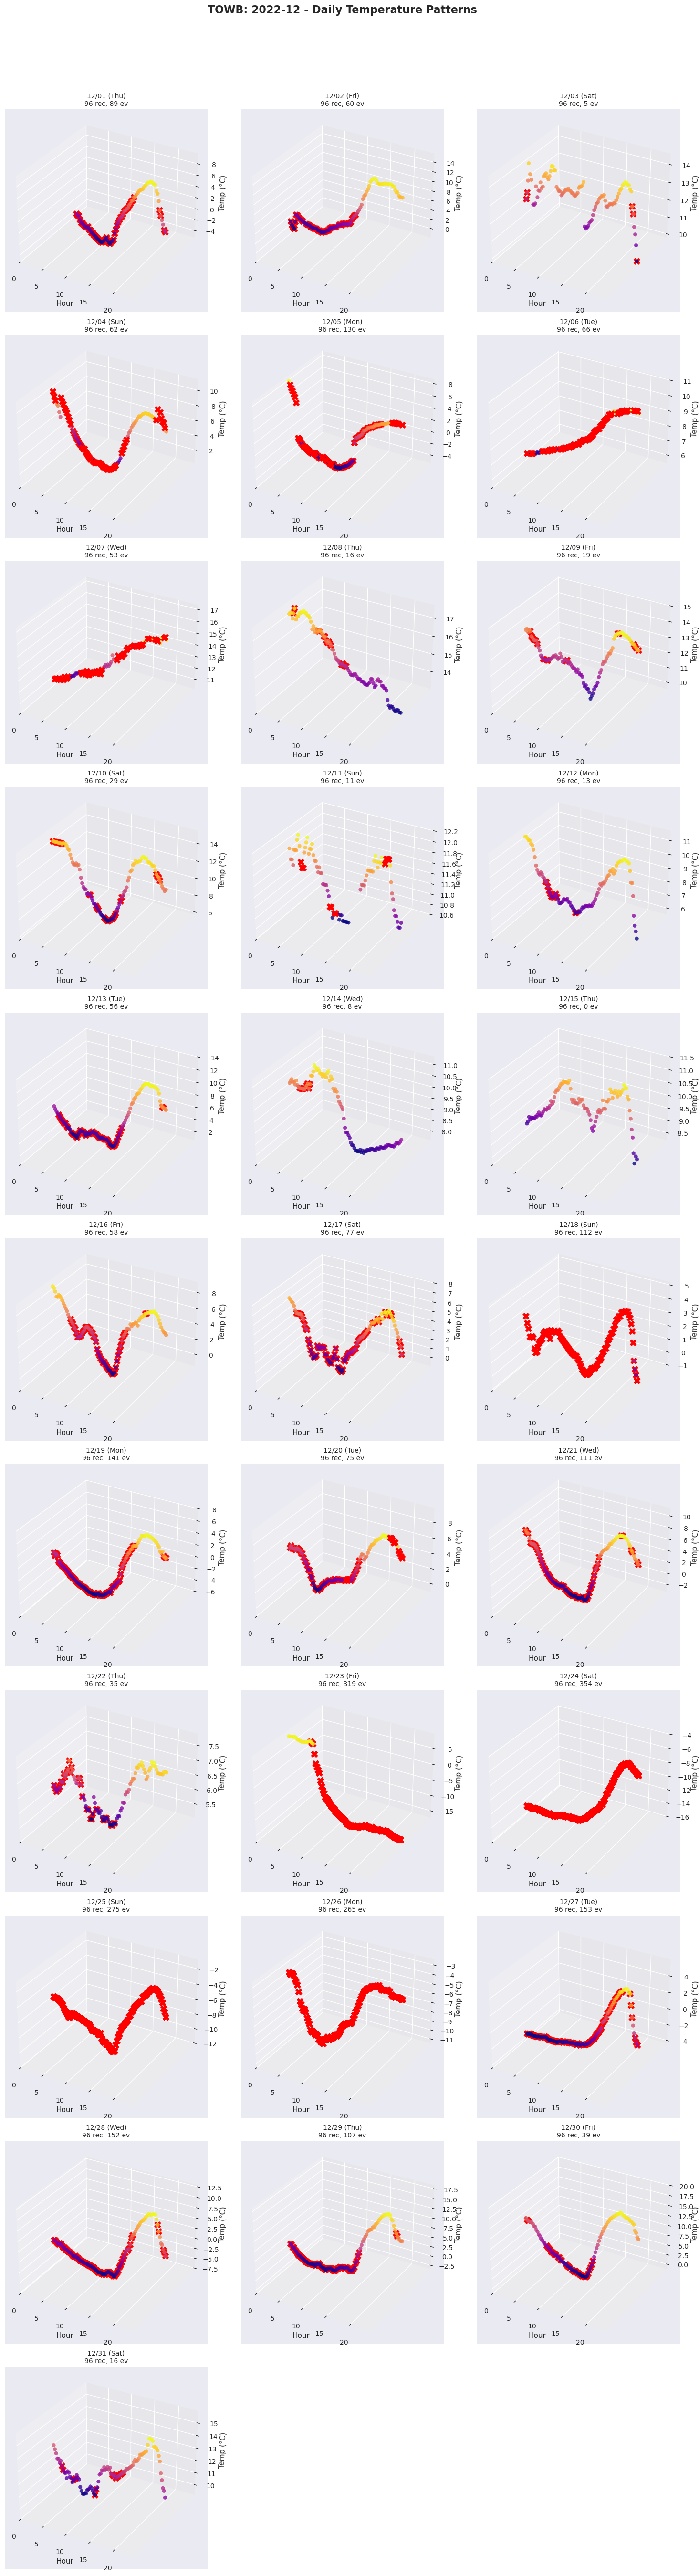

In [ ]:
# Since we have limited data, let's focus on daily patterns
print(f"\n{'='*60}")
print(f"DETAILED DAY-BY-DAY ANALYSIS: {analysis_month}")
print(f"{'='*60}")

unique_dates = sorted(month_df['date'].unique())
print(f"Days with data: {len(unique_dates)}")

# Create individual day plots
n_days = len(unique_dates)
n_cols = min(3, n_days)
n_rows = (n_days + n_cols - 1) // n_cols

fig_days = plt.figure(figsize=(15, 5 * n_rows))
fig_days.suptitle(f'TOWB: {analysis_month} - Daily Temperature Patterns', 
                  fontsize=16, fontweight='bold')

for i, date in enumerate(unique_dates):
    day_data = month_df[month_df['date'] == date].copy()
    day_name = day_data['day_name'].iloc[0] if len(day_data) > 0 else 'Unknown'
    
    ax = fig_days.add_subplot(n_rows, n_cols, i+1, projection='3d')
    
    if len(day_data) > 0:
        # Count events for this day
        day_events = 0
        for event_col in event_columns:
            if event_col in day_data.columns:
                day_events += day_data[event_col].sum()
        
        # Plot temperature throughout the day
        scatter = ax.scatter(day_data['hour_of_day'],
                           [0] * len(day_data),  # Single day level
                           day_data['TempC_030m'],
                           c=day_data['TempC_030m'],
                           cmap='plasma',
                           s=30,
                           alpha=0.8)
        
        # Add event markers
        for event_col in event_columns:
            if event_col in day_data.columns:
                event_points = day_data[day_data[event_col] == True]
                if len(event_points) > 0:
                    ax.scatter(event_points['hour_of_day'],
                              [0] * len(event_points),
                              event_points['TempC_030m'],
                              color='red',
                              marker='X',
                              s=100,
                              alpha=1.0)
        
        ax.set_xlabel('Hour')
        ax.set_ylabel('')
        ax.set_zlabel('Temp (°C)')
        ax.set_title(f'{date.strftime("%m/%d")} ({day_name[:3]})\n{len(day_data)} rec, {day_events} ev', 
                    fontsize=10)
        ax.set_yticks([])
        ax.set_xlim(0, 24)
        
    else:
        ax.text(0.5, 0.5, 0.5, f'No data for {date}', 
                ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

In [ ]:
# Generate detailed data quality report
print(f"\n{'='*60}")
print(f"DATA QUALITY REPORT: {analysis_month}")
print(f"{'='*60}")

print(f"\n📊 OVERVIEW:")
print(f"  • Total records: {len(month_df):,}")
print(f"  • Date range: {month_df['timestamp'].min().strftime('%Y-%m-%d')} to {month_df['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"  • Days with data: {len(unique_dates)}")
print(f"  • Expected records per day: 96 (24 hours × 4 intervals)")
print(f"  • Average records per day: {len(month_df)/len(unique_dates):.1f}")

print(f"\n🌡️ TEMPERATURE DATA:")
temp_available = month_df['TempC_030m'].notna().sum()
print(f"  • Available: {temp_available:,} records ({temp_available/len(month_df)*100:.1f}%)")
if temp_available > 0:
    print(f"  • Range: {month_df['TempC_030m'].min():.1f}°C to {month_df['TempC_030m'].max():.1f}°C")
    print(f"  • Average: {month_df['TempC_030m'].mean():.1f}°C")

print(f"\n📊 PRESSURE DATA:")
if 'BarPresMb_015m' in month_df.columns:
    pressure_available = month_df['BarPresMb_015m'].notna().sum()
    print(f"  • Available: {pressure_available:,} records ({pressure_available/len(month_df)*100:.1f}%)")
    if pressure_available > 0:
        print(f"  • Range: {month_df['BarPresMb_015m'].min():.1f}mb to {month_df['BarPresMb_015m'].max():.1f}mb")
else:
    print(f"  • No pressure data available")

print(f"\n⚡ EVENTS:")
total_events = 0
for event_col in event_columns:
    if event_col in month_df.columns:
        event_count = month_df[event_col].sum()
        total_events += event_count
        if event_count > 0:
            print(f"  • {event_col.replace('event_', '')}: {event_count}")
print(f"  • Total events: {total_events}")

print(f"\n🌬️ WIND DATA:")
wind_cols = ['WSpdMph_015m', 'WSpdMph_030m', 'WDir_015m', 'WDir_030m']
for col in wind_cols:
    if col in month_df.columns:
        available = month_df[col].notna().sum()
        if available > 0:
            print(f"  • {col}: {available:,} records ({available/len(month_df)*100:.1f}%)")
        else:
            print(f"  • {col}: No data")
    else:
        print(f"  • {col}: Column not found")

print(f"\n💧 PRECIPITATION:")
if 'PrecipIn_015m' in month_df.columns:
    precip_data = month_df['PrecipIn_015m'].dropna()
    if len(precip_data) > 0:
        print(f"  • Available: {len(precip_data):,} records")
        print(f"  • Total: {precip_data.sum():.2f} inches")
    else:
        print(f"  • No precipitation data")
else:
    print(f"  • Precipitation column not found")


DATA QUALITY REPORT: 2022-12

📊 OVERVIEW:
  • Total records: 2,976
  • Date range: 2022-12-01 to 2022-12-31
  • Days with data: 31
  • Expected records per day: 96 (24 hours × 4 intervals)
  • Average records per day: 96.0

🌡️ TEMPERATURE DATA:
  • Available: 2,947 records (99.0%)
  • Range: -15.5°C to 18.7°C
  • Average: 4.7°C

📊 PRESSURE DATA:
  • Available: 2,924 records (98.3%)
  • Range: 971.7mb to 1003.7mb

⚡ EVENTS:
  • E2_WindChill: 1010
  • E3_LowTemp_lt0: 760
  • E3_LowTemp_lt-5: 321
  • E3_LowTemp_lt-10: 160
  • E4_HighWind_Peak_gt25: 55
  • E5_LowWind_lt2: 600
  • Total events: 2906

🌬️ WIND DATA:
  • WSpdMph_015m: 2,966 records (99.7%)
  • WSpdMph_030m: 2,955 records (99.3%)
  • WDir_015m: 2,967 records (99.7%)
  • WDir_030m: 2,967 records (99.7%)

💧 PRECIPITATION:
  • Available: 2,966 records
  • Total: 7.14 inches


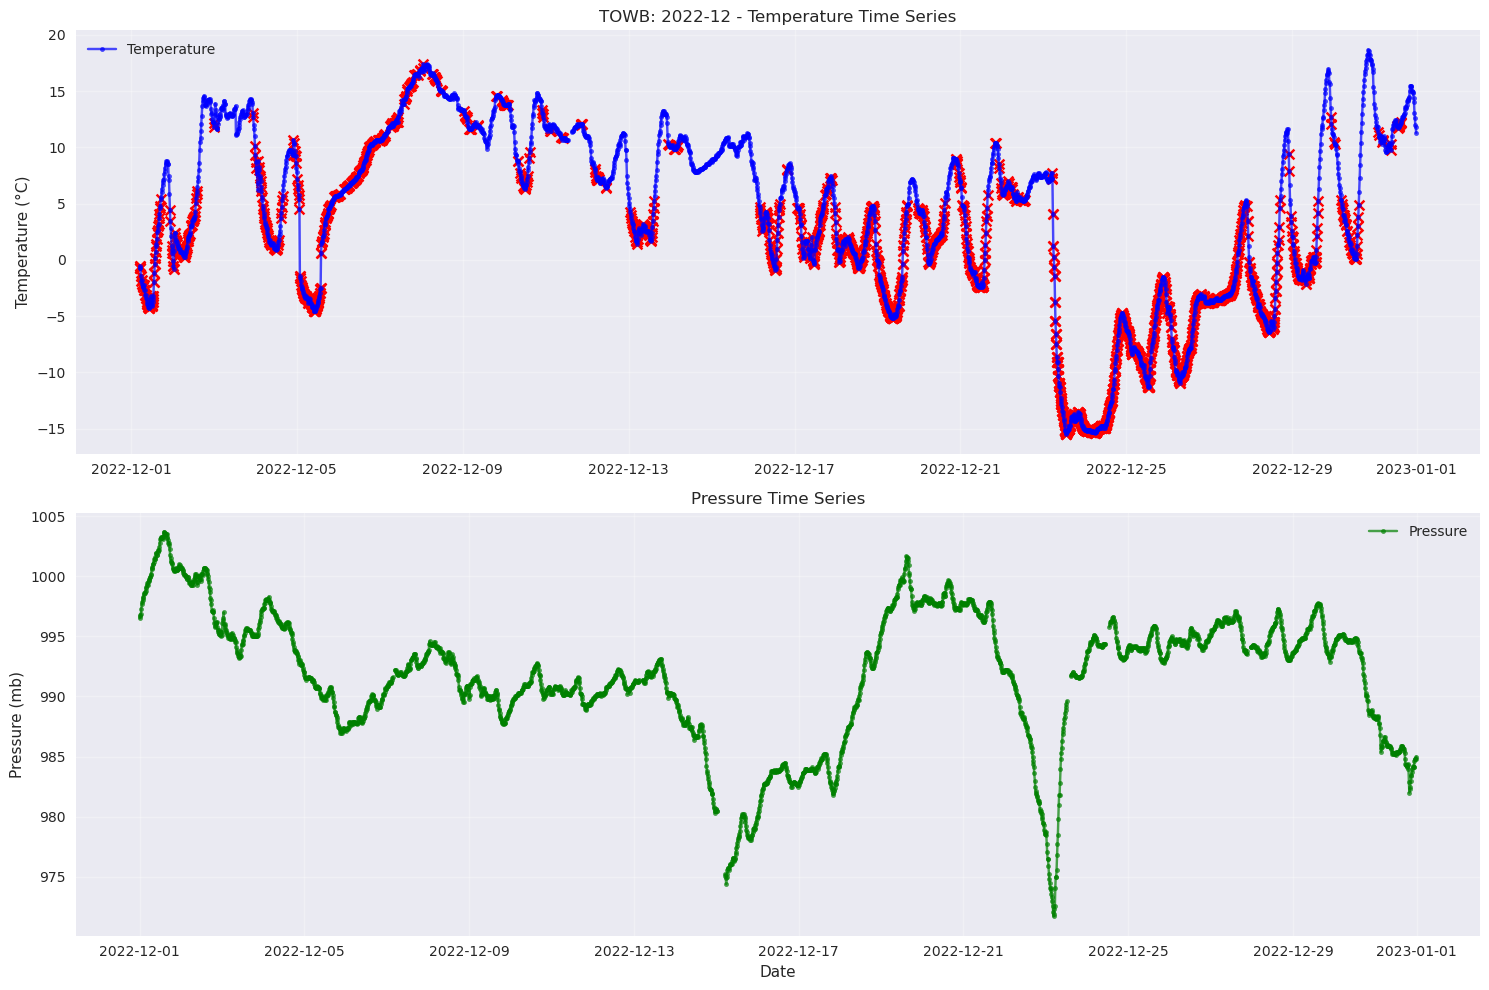

In [ ]:
# Simple time series view for the sparse data
fig_ts, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Temperature time series
ax1.plot(month_df['timestamp'], month_df['TempC_030m'], 'b.-', alpha=0.7, label='Temperature')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'TOWB: {analysis_month} - Temperature Time Series')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Mark events on temperature plot
for event_col in event_columns:
    if event_col in month_df.columns:
        event_times = month_df[month_df[event_col] == True]['timestamp']
        event_temps = month_df[month_df[event_col] == True]['TempC_030m']
        if len(event_times) > 0:
            ax1.scatter(event_times, event_temps, color='red', marker='x', s=50, 
                       label=event_col.replace('event_', ''))

# Pressure time series (if available)
if 'BarPresMb_015m' in month_df.columns and month_df['BarPresMb_015m'].notna().any():
    ax2.plot(month_df['timestamp'], month_df['BarPresMb_015m'], 'g.-', alpha=0.7, label='Pressure')
    ax2.set_ylabel('Pressure (mb)')
    ax2.set_xlabel('Date')
    ax2.set_title('Pressure Time Series')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
else:
    ax2.text(0.5, 0.5, 'No pressure data available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()

In [ ]:
# !pip3 install plotly

# Data preparation and Analysis

# Modeling

In [66]:
# SUPPORTING PAPERS:
# https://www.nature.com/articles/s41467-025-56573-8


In [67]:
# !nvidia-smi
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130
# !pip3 install optuna
# !pip3 install tscv
# !pip uninstall lightgbm -y
# !pip install lightgbm --config-settings=cmake.define.USE_GPU=ON

In [68]:
"""
QUESTION SHOULD WE FORECAST TEMP OR THE EVENT PER SE?
CLASSOFOCATOPM

"""

'\nQUESTION SHOULD WE FORECAST TEMP OR THE EVENT PER SE?\nCLASSOFOCATOPM\n\n'

In [69]:
# ==================== TEMPORAL EVENT FORECASTING - PER-TOWER EXPERIMENTS ====================
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                             precision_recall_curve, f1_score, precision_score, recall_score)
import lightgbm as lgb
import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
import optuna
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import json
from scipy import stats

warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
class EventForecastConfig:
    """Configuration for temporal event forecasting"""
    
    # ==================== FORECASTING HORIZON ====================
    FORECAST_HORIZONS = {
        '15min': 1,      # Predict event in next 15 minutes
        '30min': 2,      # Predict event in next 30 minutes
        '1hour': 4,      # Predict event in next 1 hour
        '3hours': 12,    # Predict event in next 3 hours
        '6hours': 24,    # Predict event in next 6 hours
        '12hours': 48,    # Predict event in next 12 hours
        '24hours': 96,    # Predict event in next 12 hours
    }
    SELECTED_HORIZON = '12hours'  # Change this to adjust prediction window
    
    # ==================== EVENT SELECTION ====================
    TARGET_EVENTS = [
        'event_E3_LowTemp_lt0',      # Most common, good for testing
        
    ]
    SELECTED_EVENT = 'event_E3_LowTemp_lt0'
    
    # ==================== TEMPORAL FEATURES ====================
    LAG_CONFIGS = {
        'short': [1, 2, 4, 8],           # 15min to 2hr past
        'medium': [1, 2, 4, 8, 16, 24],  # up to 6hr past
        'long': [1, 4, 8, 16, 24, 48, 96], # up to 24hr past
    }
    SELECTED_LAG_CONFIG = 'medium'
    
    ROLLING_WINDOWS = [4, 12, 24, 96]  # 1hr, 3hr, 6hr, 24hr
    
    # ==================== MODEL PARAMETERS ====================
    N_SPLITS = 5
    USE_GPU = False
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    LGBM_PARAMS = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'device': 'gpu' if USE_GPU else 'cpu',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    USE_CLASS_WEIGHTS = True
    N_TRIALS = 30
    OPTUNA_TIMEOUT = 1800

config = EventForecastConfig()

# ==================== FEATURE ENGINEERING ====================
def create_temporal_features(df: pd.DataFrame, 
                            lags: List[int],
                            rolling_windows: List[int],
                            forecast_horizon: int,
                            target_event: str) -> pd.DataFrame:
    """
    Create features respecting temporal causality (per-tower)
    """
    print("  → Creating temporal features...")
    
    df = df.sort_values('timestamp').copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Identify weather variables (exclude events)
    event_cols = [col for col in df.columns if col.startswith('event_')]
    weather_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in event_cols]
    
    feature_df = df.copy()
    
    # ==================== LAG FEATURES ====================
    for col in weather_cols:
        for lag in lags:
            feature_df[f'{col}_lag{lag}'] = feature_df[col].shift(lag)
    
    # ==================== ROLLING STATISTICS ====================
    for col in weather_cols:
        for window in rolling_windows:
            feature_df[f'{col}_rolling_mean_{window}'] = feature_df[col].rolling(
                window=window, min_periods=1).mean()
            feature_df[f'{col}_rolling_std_{window}'] = feature_df[col].rolling(
                window=window, min_periods=1).std()
            if window >= 4:
                feature_df[f'{col}_roc_{window}'] = feature_df[col].diff(window) / window
    
    # ==================== TIME FEATURES ====================
    feature_df['hour'] = feature_df['timestamp'].dt.hour
    feature_df['day_of_week'] = feature_df['timestamp'].dt.dayofweek
    feature_df['month'] = feature_df['timestamp'].dt.month
    feature_df['day_of_year'] = feature_df['timestamp'].dt.dayofyear
    feature_df['is_weekend'] = (feature_df['day_of_week'] >= 5).astype(int)
    feature_df['is_night'] = ((feature_df['hour'] >= 20) | (feature_df['hour'] <= 6)).astype(int)
    
    # Cyclical encoding
    feature_df['hour_sin'] = np.sin(2 * np.pi * feature_df['hour'] / 24)
    feature_df['hour_cos'] = np.cos(2 * np.pi * feature_df['hour'] / 24)
    feature_df['month_sin'] = np.sin(2 * np.pi * feature_df['month'] / 12)
    feature_df['month_cos'] = np.cos(2 * np.pi * feature_df['month'] / 12)
    feature_df['day_of_year_sin'] = np.sin(2 * np.pi * feature_df['day_of_year'] / 365)
    feature_df['day_of_year_cos'] = np.cos(2 * np.pi * feature_df['day_of_year'] / 365)
    
    # ==================== FUTURE TARGET ====================
    feature_df['target_event'] = feature_df[target_event].shift(-forecast_horizon)
    feature_df['target_event'] = feature_df['target_event'].fillna(False).astype(int)
    
    return feature_df

# ==================== DATA PREPARATION (PER-TOWER) ====================
def prepare_temporal_data_single_tower(tower_df: pd.DataFrame, 
                                       config: EventForecastConfig) -> Tuple[pd.DataFrame, pd.Series, List[str], pd.DataFrame]:
    """
    Prepare data for ONE tower
    """
    lags = config.LAG_CONFIGS[config.SELECTED_LAG_CONFIG]
    horizon = config.FORECAST_HORIZONS[config.SELECTED_HORIZON]
    target_event = config.SELECTED_EVENT
    
    # Check event exists
    if target_event not in tower_df.columns:
        raise ValueError(f"Column '{target_event}' not found in tower data")
    
    # Create features
    df_featured = create_temporal_features(
        tower_df, lags, config.ROLLING_WINDOWS, horizon, target_event
    )
    
    # Remove rows with NaN target
    df_featured = df_featured[~df_featured['target_event'].isna()].copy()
    
    # Define feature columns
    exclude_cols = ['tower', 'timestamp', 'target_event'] + \
                   [col for col in df_featured.columns if col.startswith('event_') and col != 'target_event']
    feature_cols = [col for col in df_featured.columns if col not in exclude_cols]
    
    # Fill NaN in features (from lag/rolling operations)
    for col in feature_cols:
        if df_featured[col].isna().any():
            df_featured[col] = df_featured[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Prepare output
    metadata = df_featured[['tower', 'timestamp', 'target_event']].copy()
    X = df_featured[feature_cols]
    y = df_featured['target_event']
    
    return X, y, feature_cols, metadata

# ==================== MODEL TRAINING (PER-TOWER) ====================
def train_single_tower_model(X: pd.DataFrame, y: pd.Series, 
                             params: Dict, config: EventForecastConfig,
                             tower_name: str,
                             metadata: pd.DataFrame = None) -> Dict:
    """
    Train model for ONE tower with time-series CV
    """
    tscv = TimeSeriesSplit(n_splits=config.N_SPLITS)
    
    results = {
        'tower': tower_name,
        'auc': [], 'f1': [], 'precision': [], 'recall': [],
        'models': [], 'fold_metadata': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Class weights
        if config.USE_CLASS_WEIGHTS:
            n_samples = len(y_train)
            n_pos = y_train.sum()
            n_neg = n_samples - n_pos
            
            weight_pos = n_samples / (2 * n_pos) if n_pos > 0 else 1.0
            weight_neg = n_samples / (2 * n_neg) if n_neg > 0 else 1.0
            
            sample_weights = np.where(y_train == 1, weight_pos, weight_neg)
        else:
            sample_weights = None
        
        # Train LightGBM
        lgb_train = lgb.Dataset(X_train, y_train, weight=sample_weights)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        # Predictions
        y_pred_proba = model.predict(X_val)
        
        # Optimal threshold
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)
        
        # Metrics
        results['auc'].append(roc_auc_score(y_val, y_pred_proba))
        results['f1'].append(f1_score(y_val, y_pred))
        results['precision'].append(precision_score(y_val, y_pred, zero_division=0))
        results['recall'].append(recall_score(y_val, y_pred, zero_division=0))
        results['models'].append(model)
        
        # Store fold metadata
        if metadata is not None:
            fold_meta = metadata.iloc[val_idx].copy()
            fold_meta['y_true'] = y_val.values
            fold_meta['y_pred_proba'] = y_pred_proba
            fold_meta['y_pred'] = y_pred
            fold_meta['fold'] = fold
            results['fold_metadata'].append(fold_meta)
    
    return results

# ==================== FEATURE IMPORTANCE ====================
def analyze_feature_importance(results: Dict, feature_cols: List[str], top_n: int = 20) -> pd.DataFrame:
    """Analyze feature importance for one tower"""
    importance_dict = {}
    for model in results['models']:
        importances = model.feature_importance(importance_type='gain')
        for feat, imp in zip(feature_cols, importances):
            if feat not in importance_dict:
                importance_dict[feat] = []
            importance_dict[feat].append(imp)
    
    importance_df = pd.DataFrame([
        {
            'feature': feat,
            'importance_mean': np.mean(imps),
            'importance_std': np.std(imps)
        }
        for feat, imps in importance_dict.items()
    ]).sort_values('importance_mean', ascending=False)
    
    return importance_df

# ==================== MAIN EXPERIMENT RUNNER ====================
def run_per_tower_experiments(filtered_dfs: Dict[str, pd.DataFrame], 
                              config: EventForecastConfig) -> Dict:
    """
    Run INDEPENDENT experiments for each tower
    """
    all_results = {}
    
    for tower_name, tower_df in filtered_dfs.items():
        print(f"\n{'='*70}")
        print(f"🏗️  TOWER: {tower_name}")
        print(f"{'='*70}")
        
        try:
            # Prepare data
            X, y, feature_cols, metadata = prepare_temporal_data_single_tower(tower_df, config)
            
            print(f"  Dataset: {X.shape[0]:,} rows × {X.shape[1]} features")
            print(f"  Event rate: {y.mean()*100:.2f}%")
            
            # Train model
            results = train_single_tower_model(X, y, config.LGBM_PARAMS, config, tower_name, metadata)
            
            # Feature importance
            importance_df = analyze_feature_importance(results, feature_cols, top_n=20)
            
            # Store results
            all_results[tower_name] = {
                'X': X,
                'y': y,
                'feature_cols': feature_cols,
                'metadata': metadata,
                'results': results,
                'importance': importance_df,
                'mean_auc': np.mean(results['auc']),
                'mean_f1': np.mean(results['f1']),
                'mean_precision': np.mean(results['precision']),
                'mean_recall': np.mean(results['recall']),
                'n_samples': len(y),
                'event_rate': y.mean()
            }
            
            print(f"\n  ✅ Results:")
            print(f"     AUC: {all_results[tower_name]['mean_auc']:.4f}")
            print(f"     F1:  {all_results[tower_name]['mean_f1']:.4f}")
            
        except Exception as e:
            print(f"\n  ❌ Error: {str(e)}")
            all_results[tower_name] = {'error': str(e)}
    
    return all_results

# ==================== COMPARISON & VISUALIZATION ====================
def compare_tower_performance(all_results: Dict) -> pd.DataFrame:
    """Compare performance across towers"""
    comparison = []
    
    for tower, res in all_results.items():
        if 'error' in res:
            comparison.append({
                'Tower': tower,
                'Status': 'FAILED',
                'Error': res['error']
            })
        else:
            comparison.append({
                'Tower': tower,
                'Status': 'SUCCESS',
                'AUC': f"{res['mean_auc']:.4f}",
                'F1': f"{res['mean_f1']:.4f}",
                'Precision': f"{res['mean_precision']:.4f}",
                'Recall': f"{res['mean_recall']:.4f}",
                'N_samples': f"{res['n_samples']:,}",
                'Event_rate_%': f"{res['event_rate']*100:.2f}"
            })
    
    df_comparison = pd.DataFrame(comparison)
    
    print("\n" + "="*80)
    print("📊 TOWER PERFORMANCE COMPARISON")
    print("="*80)
    print(df_comparison.to_string(index=False))
    
    return df_comparison

def statistical_comparison(all_results: Dict):
    """Statistical test across towers"""
    tower_aucs = {tower: res['results']['auc'] 
                  for tower, res in all_results.items() if 'error' not in res}
    
    if len(tower_aucs) < 2:
        return
    
    print("\n" + "="*80)
    print("📈 STATISTICAL COMPARISON")
    print("="*80)
    
    for tower, aucs in tower_aucs.items():
        print(f"  {tower}: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    
    all_aucs = list(tower_aucs.values())
    h_stat, p_value = stats.kruskal(*all_aucs)
    
    print(f"\nKruskal-Wallis H-test:")
    print(f"  H-statistic: {h_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  {'✅ Significant difference' if p_value < 0.05 else '❌ No significant difference'} (α=0.05)")

def visualize_comparison(all_results: Dict, config: EventForecastConfig):
    """Create comparison plots"""
    towers = []
    auc_means = []
    f1_means = []
    
    for tower, res in all_results.items():
        if 'error' not in res:
            towers.append(tower)
            auc_means.append(res['mean_auc'])
            f1_means.append(res['mean_f1'])
    
    if len(towers) == 0:
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(towers, auc_means, alpha=0.7, color='steelblue')
    axes[0].set_ylabel('AUC Score', fontsize=12)
    axes[0].set_title(f'AUC Comparison\n({config.SELECTED_EVENT}, {config.SELECTED_HORIZON})')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    axes[1].bar(towers, f1_means, alpha=0.7, color='coral')
    axes[1].set_ylabel('F1 Score', fontsize=12)
    axes[1].set_title(f'F1 Comparison\n({config.SELECTED_EVENT}, {config.SELECTED_HORIZON})')
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    event_name = config.SELECTED_EVENT.replace('event_', '')
    filename = f'tower_comparison_{event_name}_{config.SELECTED_HORIZON}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: {filename}")
    plt.show()

def save_results(all_results: Dict, config: EventForecastConfig):
    """Save all experiment results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    event_name = config.SELECTED_EVENT.replace('event_', '')
    horizon = config.SELECTED_HORIZON
    
    # Comparison table
    comparison_df = compare_tower_performance(all_results)
    comparison_df.to_csv(f'tower_comparison_{event_name}_{horizon}_{timestamp}.csv', index=False)
    
    # Feature importance per tower
    for tower, res in all_results.items():
        if 'error' not in res:
            res['importance'].to_csv(
                f'feature_importance_{tower}_{event_name}_{horizon}_{timestamp}.csv',
                index=False
            )
    
    # Full results (pickle)
    with open(f'tower_experiments_{event_name}_{horizon}_{timestamp}.pkl', 'wb') as f:
        pickle.dump(all_results, f)
    
    # Config (JSON)
    config_dict = {
        'SELECTED_EVENT': config.SELECTED_EVENT,
        'SELECTED_HORIZON': config.SELECTED_HORIZON,
        'SELECTED_LAG_CONFIG': config.SELECTED_LAG_CONFIG,
        'timestamp': timestamp
    }
    with open(f'config_{event_name}_{horizon}_{timestamp}.json', 'w') as f:
        json.dump(config_dict, f, indent=2)
    
    print(f"\n✅ All results saved with timestamp: {timestamp}")



TEMPORAL EXTREME WEATHER EVENT FORECASTING
Device: cuda
Forecast horizon: 12hours
Target event: event_E3_LowTemp_lt0
Lag configuration: medium

🏗️  TOWER: TOWA
  → Creating temporal features...


  Dataset: 210,287 rows × 373 features
  Event rate: 4.95%

  ✅ Results:
     AUC: 0.9675
     F1:  0.6274

🏗️  TOWER: TOWB
  → Creating temporal features...
  Dataset: 210,287 rows × 259 features
  Event rate: 4.71%

  ✅ Results:
     AUC: 0.9491
     F1:  0.5700

🏗️  TOWER: TOWD
  → Creating temporal features...
  Dataset: 210,287 rows × 563 features
  Event rate: 4.94%

  ✅ Results:
     AUC: 0.9651
     F1:  0.6268

🏗️  TOWER: TOWF
  → Creating temporal features...
  Dataset: 210,287 rows × 202 features
  Event rate: 4.79%

  ✅ Results:
     AUC: 0.9554
     F1:  0.5868

🏗️  TOWER: TOWS
  → Creating temporal features...
  Dataset: 210,287 rows × 164 features
  Event rate: 5.15%

  ✅ Results:
     AUC: 0.9689
     F1:  0.6445

🏗️  TOWER: TOWY
  → Creating temporal features...
  Dataset: 210,287 rows × 373 features
  Event rate: 4.69%

  ✅ Results:
     AUC: 0.9669
     F1:  0.6261

📊 TOWER PERFORMANCE COMPARISON
Tower  Status    AUC     F1 Precision Recall N_samples Event_rate_%
 TO

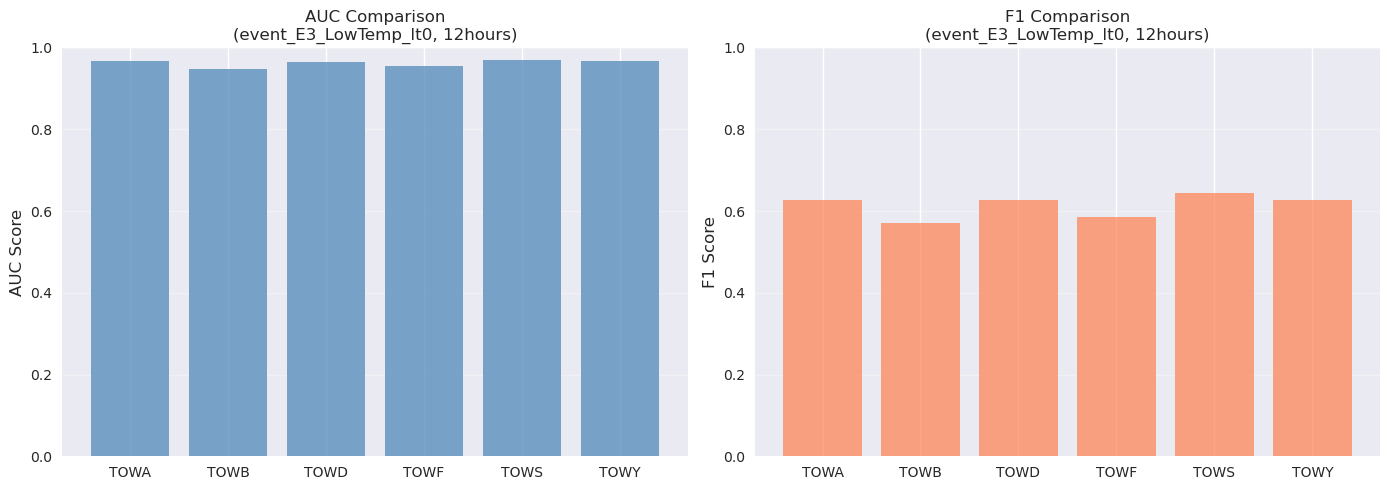


📊 TOWER PERFORMANCE COMPARISON
Tower  Status    AUC     F1 Precision Recall N_samples Event_rate_%
 TOWA SUCCESS 0.9675 0.6274    0.5756 0.6926   210,287         4.95
 TOWB SUCCESS 0.9491 0.5700    0.5574 0.5885   210,287         4.71
 TOWD SUCCESS 0.9651 0.6268    0.5991 0.6665   210,287         4.94
 TOWF SUCCESS 0.9554 0.5868    0.5627 0.6368   210,287         4.79
 TOWS SUCCESS 0.9689 0.6445    0.6185 0.6912   210,287         5.15
 TOWY SUCCESS 0.9669 0.6261    0.6063 0.6541   210,287         4.69

✅ All results saved with timestamp: 20251105_192249

✅ ALL EXPERIMENTS COMPLETE!


In [70]:

# ==================== EXECUTION ====================
print("="*70)
print("TEMPORAL EXTREME WEATHER EVENT FORECASTING")
print("="*70)
print(f"Device: {config.DEVICE}")
print(f"Forecast horizon: {config.SELECTED_HORIZON}")
print(f"Target event: {config.SELECTED_EVENT}")
print(f"Lag configuration: {config.SELECTED_LAG_CONFIG}")
print("="*70)




# Run experiments
all_tower_results = run_per_tower_experiments(filtered_dfs, config)

# Compare
comparison_df = compare_tower_performance(all_tower_results)
statistical_comparison(all_tower_results)

# Visualize
visualize_comparison(all_tower_results, config)

# Save
save_results(all_tower_results, config)

print("\n" + "="*80)
print("✅ ALL EXPERIMENTS COMPLETE!")
print("="*80)

In [71]:
# !pip3 install shap

# Wrapper 


In [72]:
# ==================== COMPREHENSIVE EXPERIMENT WRAPPER ====================
import itertools
from tqdm.auto import tqdm
import shap
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class ComprehensiveExperimentRunner:
    """Run all combinations of configurations and analyze results"""
    
    def __init__(self, filtered_dfs: Dict[str, pd.DataFrame]):
        self.filtered_dfs = filtered_dfs
        self.all_experiment_results = []
        self.summary_df = None
        # self.filtered_dfs = filtered_dfs
        # self.all_experiment_results = []
        # self.summary_df = None
        

    

    def plot_3d_performance_surface(self, metric='auc'):
        """
        Create 3D surface plot: Lag Config × Horizon × Performance
        """
        if self.summary_df is None or len(self.summary_df) == 0:
            print("❌ No results to visualize")
            return
        
        # Prepare data for 3D plot
        pivot_data = self.summary_df.groupby(['lag_config', 'horizon'])[metric].mean().unstack()
        
        # Create numeric mappings
        lag_mapping = {'short': 0, 'medium': 1, 'long': 2}
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizon_mapping = {h: i for i, h in enumerate(horizon_order)}
        
        # Build meshgrid
        lags_present = [lag_mapping[l] for l in pivot_data.index if l in lag_mapping]
        horizons_present = [horizon_mapping[h] for h in pivot_data.columns if h in horizon_mapping]
        
        if len(lags_present) == 0 or len(horizons_present) == 0:
            print("❌ Insufficient data for 3D plot")
            return
        
        X, Y = np.meshgrid(horizons_present, lags_present)
        Z = np.zeros_like(X, dtype=float)
        
        for i, lag in enumerate(pivot_data.index):
            for j, horizon in enumerate(pivot_data.columns):
                if lag in lag_mapping and horizon in horizon_mapping:
                    lag_idx = lags_present.index(lag_mapping[lag])
                    horizon_idx = horizons_present.index(horizon_mapping[horizon])
                    Z[lag_idx, horizon_idx] = pivot_data.loc[lag, horizon]
        
        # Create 3D plot
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Surface plot
        surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, 
                              alpha=0.8, edgecolor='k', linewidth=0.5)
        
        # Scatter points on surface
        ax.scatter(X, Y, Z, c=Z, cmap=cm.viridis, s=100, 
                  edgecolors='black', linewidth=1.5, alpha=1.0)
        
        # Labels
        ax.set_xlabel('Forecast Horizon', fontsize=12, labelpad=10)
        ax.set_ylabel('Lag Configuration', fontsize=12, labelpad=10)
        ax.set_zlabel(f'{metric.upper()} Score', fontsize=12, labelpad=10)
        
        # Tick labels
        ax.set_xticks(horizons_present)
        ax.set_xticklabels([horizon_order[i] for i in horizons_present], rotation=45)
        ax.set_yticks(lags_present)
        ax.set_yticklabels([k for k, v in lag_mapping.items() if v in lags_present])
        
        ax.set_title(f'3D Performance Surface: {metric.upper()}\n(Averaged across towers & events)', 
                    fontsize=14, pad=20)
        
        # Colorbar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        
        # Viewing angle
        ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        filename = f'3d_surface_{metric}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"✅ Saved: {filename}")
        plt.show()
    
    def plot_3d_event_comparison(self):
        """
        3D scatter: Event × Horizon × AUC (colored by lag config)
        """
        if self.summary_df is None or len(self.summary_df) == 0:
            return
        
        # Get unique events and horizons
        events = self.summary_df['event'].unique()
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizons = [h for h in horizon_order if h in self.summary_df['horizon'].unique()]
        
        event_mapping = {e: i for i, e in enumerate(events)}
        horizon_mapping = {h: i for i, h in enumerate(horizons)}
        lag_colors = {'short': 'blue', 'medium': 'green', 'long': 'red'}
        
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot each lag config separately for legend
        for lag_config in ['short', 'medium', 'long']:
            subset = self.summary_df[self.summary_df['lag_config'] == lag_config]
            
            if len(subset) == 0:
                continue
            
            x = [event_mapping[e] for e in subset['event']]
            y = [horizon_mapping[h] for h in subset['horizon']]
            z = subset['auc'].values
            
            ax.scatter(x, y, z, c=lag_colors[lag_config], 
                      s=100, alpha=0.7, edgecolors='black', 
                      linewidth=1, label=f'Lag: {lag_config}')
        
        ax.set_xlabel('Event Type', fontsize=12, labelpad=10)
        ax.set_ylabel('Forecast Horizon', fontsize=12, labelpad=10)
        ax.set_zlabel('AUC Score', fontsize=12, labelpad=10)
        
        ax.set_xticks(range(len(events)))
        ax.set_xticklabels([e.split('_')[1] for e in events], rotation=45, ha='right')
        ax.set_yticks(range(len(horizons)))
        ax.set_yticklabels(horizons, rotation=-15)
        
        ax.set_title('3D Event Comparison: AUC by Event × Horizon × Lag Config', 
                    fontsize=14, pad=20)
        ax.legend(loc='upper left', fontsize=10)
        ax.view_init(elev=20, azim=45)
        
        plt.tight_layout()
        plt.savefig('3d_event_comparison.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: 3d_event_comparison.png")
        plt.show()
    
    def plot_3d_tower_performance(self):
        """
        3D bar chart: Tower × Event × AUC
        """
        if self.summary_df is None or len(self.summary_df) == 0:
            return
        
        # Aggregate by tower and event (average across horizons/lags)
        agg_data = self.summary_df.groupby(['tower', 'event'])['auc'].mean().reset_index()
        
        towers = agg_data['tower'].unique()
        events = agg_data['event'].unique()
        
        tower_mapping = {t: i for i, t in enumerate(towers)}
        event_mapping = {e: i for i, e in enumerate(events)}
        
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create bars
        for _, row in agg_data.iterrows():
            x = tower_mapping[row['tower']]
            y = event_mapping[row['event']]
            z = row['auc']
            
            color = cm.viridis(z)
            ax.bar3d(x, y, 0, 0.6, 0.6, z, color=color, 
                    alpha=0.8, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Tower', fontsize=12, labelpad=10)
        ax.set_ylabel('Event Type', fontsize=12, labelpad=10)
        ax.set_zlabel('AUC Score', fontsize=12, labelpad=10)
        
        ax.set_xticks(range(len(towers)))
        ax.set_xticklabels(towers)
        ax.set_yticks(range(len(events)))
        ax.set_yticklabels([e.split('_')[1] for e in events], rotation=45, ha='right')
        
        ax.set_title('3D Tower Performance: AUC by Tower × Event', 
                    fontsize=14, pad=20)
        ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        plt.savefig('3d_tower_performance.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: 3d_tower_performance.png")
        plt.show()
    
    def plot_3d_multi_metric_comparison(self):
        """
        Multiple 3D plots for different metrics
        """
        if self.summary_df is None or len(self.summary_df) == 0:
            return
        
        metrics = ['auc', 'f1', 'precision', 'recall']
        
        fig = plt.figure(figsize=(20, 16))
        
        for idx, metric in enumerate(metrics, 1):
            ax = fig.add_subplot(2, 2, idx, projection='3d')
            
            # Prepare data
            pivot_data = self.summary_df.groupby(['lag_config', 'horizon'])[metric].mean().unstack()
            
            if pivot_data.empty:
                continue
            
            lag_mapping = {'short': 0, 'medium': 1, 'long': 2}
            horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
            horizon_mapping = {h: i for i, h in enumerate(horizon_order)}
            
            lags_present = [lag_mapping[l] for l in pivot_data.index if l in lag_mapping]
            horizons_present = [horizon_mapping[h] for h in pivot_data.columns if h in horizon_mapping]
            
            if len(lags_present) == 0 or len(horizons_present) == 0:
                continue
            
            X, Y = np.meshgrid(horizons_present, lags_present)
            Z = np.zeros_like(X, dtype=float)
            
            for i, lag in enumerate(pivot_data.index):
                for j, horizon in enumerate(pivot_data.columns):
                    if lag in lag_mapping and horizon in horizon_mapping:
                        lag_idx = lags_present.index(lag_mapping[lag])
                        horizon_idx = horizons_present.index(horizon_mapping[horizon])
                        Z[lag_idx, horizon_idx] = pivot_data.loc[lag, horizon]
            
            # Plot
            surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.7)
            ax.scatter(X, Y, Z, c=Z, cmap=cm.coolwarm, s=50, edgecolors='black')
            
            ax.set_xlabel('Horizon', fontsize=10)
            ax.set_ylabel('Lag', fontsize=10)
            ax.set_zlabel(metric.upper(), fontsize=10)
            ax.set_title(f'{metric.upper()} Surface', fontsize=12)
            
            ax.set_xticks(horizons_present)
            ax.set_xticklabels([horizon_order[i] for i in horizons_present], 
                              rotation=45, fontsize=8)
            ax.set_yticks(lags_present)
            ax.set_yticklabels([k for k, v in lag_mapping.items() if v in lags_present],
                              fontsize=8)
            
            ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        plt.savefig('3d_multi_metric_comparison.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: 3d_multi_metric_comparison.png")
        plt.show()
    
    def plot_3d_interactive_summary(self):
        """
        Create animated 3D plot showing performance from multiple angles
        """
        if self.summary_df is None or len(self.summary_df) == 0:
            return
        
        print("\n🎬 Creating animated 3D visualization...")
        
        # Prepare data
        pivot_data = self.summary_df.groupby(['lag_config', 'horizon'])['auc'].mean().unstack()
        
        lag_mapping = {'short': 0, 'medium': 1, 'long': 2}
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizon_mapping = {h: i for i, h in enumerate(horizon_order)}
        
        lags_present = [lag_mapping[l] for l in pivot_data.index if l in lag_mapping]
        horizons_present = [horizon_mapping[h] for h in pivot_data.columns if h in horizon_mapping]
        
        X, Y = np.meshgrid(horizons_present, lags_present)
        Z = np.zeros_like(X, dtype=float)
        
        for i, lag in enumerate(pivot_data.index):
            for j, horizon in enumerate(pivot_data.columns):
                if lag in lag_mapping and horizon in horizon_mapping:
                    lag_idx = lags_present.index(lag_mapping[lag])
                    horizon_idx = horizons_present.index(horizon_mapping[horizon])
                    Z[lag_idx, horizon_idx] = pivot_data.loc[lag, horizon]
        
        # Create multiple views
        elevations = [15, 25, 35]
        azimuths = [30, 60, 90, 120]
        
        fig = plt.figure(figsize=(20, 15))
        
        plot_idx = 1
        for elev in elevations:
            for azim in azimuths:
                if plot_idx > 12:
                    break
                    
                ax = fig.add_subplot(3, 4, plot_idx, projection='3d')
                
                surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma, alpha=0.8)
                ax.scatter(X, Y, Z, c=Z, cmap=cm.plasma, s=50, edgecolors='black')
                
                ax.set_xlabel('Horizon', fontsize=8)
                ax.set_ylabel('Lag', fontsize=8)
                ax.set_zlabel('AUC', fontsize=8)
                ax.set_title(f'View: elev={elev}°, azim={azim}°', fontsize=10)
                
                ax.set_xticks(horizons_present[::2])  # Show every other
                ax.set_xticklabels([horizon_order[i] for i in horizons_present[::2]], 
                                  rotation=45, fontsize=6)
                ax.set_yticks(lags_present)
                ax.set_yticklabels([k for k, v in lag_mapping.items() if v in lags_present],
                                  fontsize=6)
                
                ax.view_init(elev=elev, azim=azim)
                plot_idx += 1
        
        plt.suptitle('3D Performance Surface - Multiple Views', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.savefig('3d_multi_view_summary.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: 3d_multi_view_summary.png")
        plt.show()
    
    def visualize_all_results(self):
        """Create comprehensive visualization of all results"""
        if self.summary_df is None or len(self.summary_df) == 0:
            print("❌ No results to visualize")
            return
        
        print("\n" + "="*80)
        print("📊 GENERATING ALL VISUALIZATIONS")
        print("="*80)
        
        # Original 2D plots
        print("\n1️⃣  Creating 2D heatmaps...")
        self._plot_performance_heatmap()
        
        print("\n2️⃣  Creating lag config comparison...")
        self._plot_lag_config_comparison()
        
        print("\n3️⃣  Creating tower comparison...")
        self._plot_tower_comparison()
        
        print("\n4️⃣  Creating top configurations ranking...")
        self._plot_top_configurations()
        
        # New 3D plots
        print("\n5️⃣  Creating 3D performance surfaces...")
        for metric in ['auc', 'f1', 'precision', 'recall']:
            self.plot_3d_performance_surface(metric=metric)
        
        print("\n6️⃣  Creating 3D event comparison...")
        self.plot_3d_event_comparison()
        
        print("\n7️⃣  Creating 3D tower performance...")
        self.plot_3d_tower_performance()
        
        print("\n8️⃣  Creating 3D multi-metric comparison...")
        self.plot_3d_multi_metric_comparison()
        
        print("\n9️⃣  Creating 3D multi-view summary...")
        self.plot_3d_interactive_summary()
        
        # SHAP plots (if available)
        if hasattr(self, 'shap_results'):
            print("\n🔟  Creating SHAP summary plots...")
            self._plot_shap_summaries()
        
        print("\n" + "="*80)
        print("✅ ALL VISUALIZATIONS COMPLETE!")
        print("="*80)

    def run_all_combinations(self, 
                            events: List[str] = None,
                            horizons: List[str] = None,
                            lag_configs: List[str] = None):
        """
        Run experiments for all combinations
        """
        # Default to all options if not specified
        if events is None:
            events = [
                'event_E1_TempMoistHaz',
                'event_E2_WindChill',
                'event_E3_LowTemp_lt0',
                'event_E3_LowTemp_lt-5',
                'event_E3_LowTemp_lt-10',
                'event_E4_HighWind_Peak_gt25',
                'event_E5_LowWind_lt2',
                'event_E5_LowWind_lt1',
                'event_E5_LowWind_lt0_5'
            ]
        
        if horizons is None:
            horizons = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        
        if lag_configs is None:
            lag_configs = ['short', 'medium', 'long']
        
        # Generate all combinations
        combinations = list(itertools.product(events, horizons, lag_configs))
        
        print(f"🚀 Running {len(combinations)} total combinations...")
        print(f"   Events: {len(events)}")
        print(f"   Horizons: {len(horizons)}")
        print(f"   Lag configs: {len(lag_configs)}")
        print(f"   Total: {len(combinations)} experiments\n")
        
        # Progress bar for all combinations
        pbar = tqdm(combinations, desc="Overall Progress", position=0)
        
        for event, horizon, lag_config in pbar:
            pbar.set_description(f"Event: {event.split('_')[1]}, Horizon: {horizon}, Lags: {lag_config}")
            
            try:
                # Create config for this combination
                config = EventForecastConfig()
                config.SELECTED_EVENT = event
                config.SELECTED_HORIZON = horizon
                config.SELECTED_LAG_CONFIG = lag_config
                
                # Run experiment
                results = self._run_single_experiment(config)
                
                # Store results
                self.all_experiment_results.append({
                    'event': event,
                    'horizon': horizon,
                    'lag_config': lag_config,
                    'results': results,
                    'config': config
                })
                
            except Exception as e:
                print(f"\n❌ Failed: {event}, {horizon}, {lag_config}")
                print(f"   Error: {str(e)}\n")
                self.all_experiment_results.append({
                    'event': event,
                    'horizon': horizon,
                    'lag_config': lag_config,
                    'results': {'error': str(e)},
                    'config': None
                })
        
        print("\n✅ All experiments complete!")
        self._create_summary()
        
    def _run_single_experiment(self, config: EventForecastConfig) -> Dict:
        """Run single experiment configuration"""
        tower_results = {}
        
        # Progress bar for towers
        tower_pbar = tqdm(self.filtered_dfs.items(), 
                         desc=f"  Towers", 
                         position=1, 
                         leave=False)
        
        for tower_name, tower_df in tower_pbar:
            tower_pbar.set_description(f"  Tower: {tower_name}")
            
            try:
                # Check if event exists in this tower's data
                if config.SELECTED_EVENT not in tower_df.columns:
                    continue
                
                # Prepare data
                X, y, feature_cols, metadata = prepare_temporal_data_single_tower(tower_df, config)
                
                # Skip if insufficient data
                if len(y) < 100 or y.sum() < 10:
                    continue
                
                # Train model
                results = train_single_tower_model(X, y, config.LGBM_PARAMS, config, tower_name, metadata)
                
                # Feature importance
                importance_df = analyze_feature_importance(results, feature_cols, top_n=20)
                
                tower_results[tower_name] = {
                    'X': X,
                    'y': y,
                    'feature_cols': feature_cols,
                    'results': results,
                    'importance': importance_df,
                    'mean_auc': np.mean(results['auc']),
                    'mean_f1': np.mean(results['f1']),
                    'mean_precision': np.mean(results['precision']),
                    'mean_recall': np.mean(results['recall']),
                    'n_samples': len(y),
                    'event_rate': y.mean()
                }
                
            except Exception as e:
                tower_results[tower_name] = {'error': str(e)}
        
        return tower_results
    
    def _create_summary(self):
        """Create summary DataFrame of all experiments"""
        summary_data = []
        
        for exp in self.all_experiment_results:
            if 'error' in exp['results']:
                continue
                
            for tower, tower_res in exp['results'].items():
                if 'error' in tower_res:
                    continue
                    
                summary_data.append({
                    'event': exp['event'],
                    'horizon': exp['horizon'],
                    'lag_config': exp['lag_config'],
                    'tower': tower,
                    'auc': tower_res['mean_auc'],
                    'f1': tower_res['mean_f1'],
                    'precision': tower_res['mean_precision'],
                    'recall': tower_res['mean_recall'],
                    'n_samples': tower_res['n_samples'],
                    'event_rate': tower_res['event_rate']
                })
        
        self.summary_df = pd.DataFrame(summary_data)
        print(f"\n📊 Summary created: {len(self.summary_df)} successful experiments")
    
    def get_top_configurations(self, metric='auc', n=5) -> pd.DataFrame:
        """Get top N configurations by metric"""
        if self.summary_df is None:
            return None
        
        # Average across towers for each configuration
        config_performance = self.summary_df.groupby(['event', 'horizon', 'lag_config'])[metric].mean()
        top_configs = config_performance.nlargest(n)
        
        return top_configs.reset_index()
    
    def generate_shap_explanations(self, n_top=5):
        """Generate SHAP explanations for top N configurations"""
        print(f"\n🔍 Generating SHAP explanations for top {n_top} configurations...")
        
        top_configs = self.get_top_configurations(metric='auc', n=n_top)
        
        if top_configs is None or len(top_configs) == 0:
            print("❌ No successful experiments to explain")
            return
        
        shap_results = []
        
        for idx, row in tqdm(top_configs.iterrows(), total=len(top_configs), desc="SHAP Analysis"):
            event = row['event']
            horizon = row['horizon']
            lag_config = row['lag_config']
            
            print(f"\n📍 Config: {event} | {horizon} | {lag_config}")
            
            # Find matching experiment
            matching_exp = None
            for exp in self.all_experiment_results:
                if (exp['event'] == event and 
                    exp['horizon'] == horizon and 
                    exp['lag_config'] == lag_config):
                    matching_exp = exp
                    break
            
            if matching_exp is None:
                continue
            
            # Generate SHAP for each tower
            for tower, tower_res in matching_exp['results'].items():
                if 'error' in tower_res:
                    continue
                
                try:
                    # Use first fold's model for SHAP
                    model = tower_res['results']['models'][0]
                    X_sample = tower_res['X'].sample(min(1000, len(tower_res['X'])))
                    
                    # TreeExplainer for LightGBM
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_sample)
                    
                    # Store results
                    shap_results.append({
                        'event': event,
                        'horizon': horizon,
                        'lag_config': lag_config,
                        'tower': tower,
                        'explainer': explainer,
                        'shap_values': shap_values,
                        'X_sample': X_sample,
                        'feature_names': tower_res['feature_cols']
                    })
                    
                except Exception as e:
                    print(f"   ⚠️  SHAP failed for {tower}: {str(e)}")
        
        self.shap_results = shap_results
        print(f"\n✅ Generated SHAP explanations for {len(shap_results)} tower-configs")
    
    def visualize_all_results(self):
        """Create comprehensive visualization of all results"""
        if self.summary_df is None or len(self.summary_df) == 0:
            print("❌ No results to visualize")
            return
        
        # 1. Heatmap: Event × Horizon (averaged across towers)
        self._plot_performance_heatmap()
        
        # 2. Lag config comparison
        self._plot_lag_config_comparison()
        
        # 3. Tower comparison across all configs
        self._plot_tower_comparison()
        
        # 4. Best configurations summary
        self._plot_top_configurations()
        
        # 5. SHAP summary plots (if available)
        if hasattr(self, 'shap_results'):
            self._plot_shap_summaries()
    
    def _plot_performance_heatmap(self):
        """Heatmap of performance across events and horizons"""
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        
        for idx, metric in enumerate(['auc', 'f1']):
            pivot = self.summary_df.groupby(['event', 'horizon'])[metric].mean().unstack()
            
            # Sort by horizon order
            horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
            pivot = pivot[[h for h in horizon_order if h in pivot.columns]]
            
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                       vmin=0.5, vmax=1.0, ax=axes[idx])
            axes[idx].set_title(f'{metric.upper()} Performance Heatmap\n(Averaged across towers & lag configs)')
            axes[idx].set_xlabel('Forecast Horizon')
            axes[idx].set_ylabel('Event Type')
        
        plt.tight_layout()
        plt.savefig('comprehensive_heatmap.png', dpi=150, bbox_inches='tight')
        print("\n✅ Saved: comprehensive_heatmap.png")
        plt.show()
    
    def _plot_lag_config_comparison(self):
        """Compare lag configurations"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, metric in enumerate(['auc', 'f1', 'recall']):
            data = self.summary_df.groupby('lag_config')[metric].agg(['mean', 'std'])
            
            axes[idx].bar(data.index, data['mean'], yerr=data['std'], 
                         alpha=0.7, capsize=5, color='steelblue')
            axes[idx].set_ylabel(metric.upper())
            axes[idx].set_title(f'{metric.upper()} by Lag Configuration')
            axes[idx].set_ylim([0, 1])
            axes[idx].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('lag_config_comparison.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: lag_config_comparison.png")
        plt.show()
    
    def _plot_tower_comparison(self):
        """Compare performance across towers"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        for idx, metric in enumerate(['auc', 'f1', 'precision', 'recall']):
            ax = axes[idx // 2, idx % 2]
            data = self.summary_df.groupby('tower')[metric].agg(['mean', 'std'])
            data = data.sort_values('mean', ascending=False)
            
            ax.bar(data.index, data['mean'], yerr=data['std'], 
                  alpha=0.7, capsize=5, color='coral')
            ax.set_ylabel(metric.upper())
            ax.set_title(f'{metric.upper()} by Tower\n(Averaged across all configs)')
            ax.set_ylim([0, 1])
            ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('tower_comparison_all_configs.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: tower_comparison_all_configs.png")
        plt.show()
    
    def _plot_top_configurations(self):
        """Plot top configurations"""
        top_configs = self.get_top_configurations(metric='auc', n=10)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        labels = [f"{row['event'].split('_')[1]}\n{row['horizon']}\n{row['lag_config']}" 
                 for _, row in top_configs.iterrows()]
        
        ax.barh(labels, top_configs['auc'], alpha=0.7, color='seagreen')
        ax.set_xlabel('AUC Score')
        ax.set_title('Top 10 Configurations by AUC')
        ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('top_10_configurations.png', dpi=150, bbox_inches='tight')
        print("✅ Saved: top_10_configurations.png")
        plt.show()
    
    def _plot_shap_summaries(self):
        """Plot SHAP summary for top configurations"""
        if not hasattr(self, 'shap_results') or len(self.shap_results) == 0:
            return
        
        print("\n📊 Creating SHAP summary plots...")
        
        for shap_res in self.shap_results[:5]:  # Top 5 only
            config_name = f"{shap_res['event']}_{shap_res['horizon']}_{shap_res['lag_config']}_{shap_res['tower']}"
            
            plt.figure(figsize=(10, 8))
            shap.summary_plot(
                shap_res['shap_values'], 
                shap_res['X_sample'],
                feature_names=shap_res['feature_names'],
                show=False,
                max_display=20
            )
            plt.title(f"SHAP Summary: {config_name}")
            plt.tight_layout()
            plt.savefig(f'shap_summary_{config_name}.png', dpi=150, bbox_inches='tight')
            plt.close()
            
        print(f"✅ Saved SHAP plots for {min(5, len(self.shap_results))} configurations")
    
    def save_comprehensive_results(self):
        """Save all results"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Summary CSV
        if self.summary_df is not None:
            self.summary_df.to_csv(f'comprehensive_results_{timestamp}.csv', index=False)
            print(f"\n✅ Saved: comprehensive_results_{timestamp}.csv")
        
        # Top configurations
        top_configs = self.get_top_configurations(metric='auc', n=20)
        if top_configs is not None:
            top_configs.to_csv(f'top_20_configurations_{timestamp}.csv', index=False)
            print(f"✅ Saved: top_20_configurations_{timestamp}.csv")
        
        # Full results (pickle)
        with open(f'all_experiments_{timestamp}.pkl', 'wb') as f:
            pickle.dump(self.all_experiment_results, f)
        print(f"✅ Saved: all_experiments_{timestamp}.pkl")


# ==================== EXECUTION ====================
print("="*80)
print("🚀 COMPREHENSIVE EXPERIMENT RUNNER WITH 3D VISUALIZATION")
print("="*80)

runner = ComprehensiveExperimentRunner(filtered_dfs)

# Run all combinations (specify subset for testing)
runner.run_all_combinations(
    events=['event_E3_LowTemp_lt0'],   #, 'event_E2_WindChill'
    horizons=['1hour', '3hours', '6hours', '12hours'],
    lag_configs=['short', 'medium', 'long']
)

# Generate SHAP for top 5
runner.generate_shap_explanations(n_top=5)

# Visualize everything (including 3D plots)
runner.visualize_all_results()

# Save results
runner.save_comprehensive_results()

print("\n" + "="*80)
print("✅ COMPREHENSIVE ANALYSIS COMPLETE!")
print("="*80)

🚀 COMPREHENSIVE EXPERIMENT RUNNER WITH 3D VISUALIZATION
🚀 Running 12 total combinations...
   Events: 1
   Horizons: 4
   Lag configs: 3
   Total: 12 experiments



Event: E3, Horizon: 1hour, Lags: short:   0%|          | 0/12 [00:00<?, ?it/s]

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 1hour, Lags: medium:   8%|▊         | 1/12 [00:54<10:01, 54.68s/it]

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 1hour, Lags: long:  17%|█▋        | 2/12 [01:57<09:51, 59.19s/it]  

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 3hours, Lags: short:  25%|██▌       | 3/12 [03:05<09:32, 63.60s/it]

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 3hours, Lags: medium:  33%|███▎      | 4/12 [04:07<08:22, 62.79s/it]

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 3hours, Lags: long:  42%|████▏     | 5/12 [05:11<07:22, 63.22s/it]  

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 6hours, Lags: short:  50%|█████     | 6/12 [06:18<06:26, 64.40s/it]

  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


  → Creating temporal features...


Event: E3, Horizon: 6hours, Lags: medium:  58%|█████▊    | 7/12 [07:21<05:19, 63.93s/it]

  → Creating temporal features...


Event: E3, Horizon: 6hours, Lags: medium:  58%|█████▊    | 7/12 [07:23<05:17, 63.41s/it]


KeyboardInterrupt: 

# Extra Viz

In [ ]:
"""
Standalone Analysis Script for Saved Experiment Results
Reads all_experiments_*.pkl and generates comprehensive visualizations
"""

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from typing import Dict, List
import warnings
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

warnings.filterwarnings('ignore')

class ExperimentAnalyzer:
    """Analyze saved experiment results from pickle file"""
    
    def __init__(self, pkl_path: str):
        """
        Load experiments from pickle file
        
        Args:
            pkl_path: Path to all_experiments_*.pkl file
        """
        print(f"📂 Loading experiments from: {pkl_path}")
        
        with open(pkl_path, 'rb') as f:
            self.all_experiment_results = pickle.load(f)
        
        print(f"✅ Loaded {len(self.all_experiment_results)} experiments")
        
        # Create summary DataFrame
        self.summary_df = self._create_summary_dataframe()
        
        # Create output directory
        self.output_dir = Path(f"analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        self.output_dir.mkdir(exist_ok=True)
        print(f"📁 Output directory: {self.output_dir}")
    
    def _create_summary_dataframe(self) -> pd.DataFrame:
        """Convert experiment results to summary DataFrame"""
        summary_data = []
        
        for exp in self.all_experiment_results:
            if 'error' in exp['results']:
                continue
            
            for tower, tower_res in exp['results'].items():
                if 'error' in tower_res:
                    continue
                
                summary_data.append({
                    'event': exp['event'],
                    'horizon': exp['horizon'],
                    'lag_config': exp['lag_config'],
                    'tower': tower,
                    'auc': tower_res['mean_auc'],
                    'f1': tower_res['mean_f1'],
                    'precision': tower_res['mean_precision'],
                    'recall': tower_res['mean_recall'],
                    'n_samples': tower_res['n_samples'],
                    'event_rate': tower_res['event_rate']
                })
        
        df = pd.DataFrame(summary_data)
        print(f"\n📊 Summary DataFrame: {len(df)} successful experiments")
        
        if len(df) > 0:
            print(f"   Events: {df['event'].nunique()}")
            print(f"   Horizons: {df['horizon'].nunique()}")
            print(f"   Lag configs: {df['lag_config'].nunique()}")
            print(f"   Towers: {df['tower'].nunique()}")
        
        return df
    
    def generate_all_visualizations(self):
        """Generate all visualization types"""
        print("\n" + "="*80)
        print("🎨 GENERATING ALL VISUALIZATIONS")
        print("="*80)
        
        if self.summary_df.empty:
            print("❌ No data to visualize")
            return
        
        # 2D Visualizations
        print("\n1️⃣  2D Heatmaps...")
        self.plot_performance_heatmaps()
        
        print("\n2️⃣  Lag Config Comparison...")
        self.plot_lag_config_comparison()
        
        print("\n3️⃣  Tower Comparison...")
        self.plot_tower_comparison()
        
        print("\n4️⃣  Horizon Analysis...")
        self.plot_horizon_analysis()
        
        print("\n5️⃣  Event Comparison...")
        self.plot_event_comparison()
        
        print("\n6️⃣  Top Configurations...")
        self.plot_top_configurations()
        
        # 3D Visualizations
        print("\n7️⃣  3D Performance Surfaces...")
        for metric in ['auc', 'f1', 'precision', 'recall']:
            self.plot_3d_performance_surface(metric=metric)
        
        print("\n8️⃣  3D Event Comparison...")
        self.plot_3d_event_comparison()
        
        print("\n9️⃣  3D Tower Performance...")
        self.plot_3d_tower_performance()
        
        print("\n🔟  3D Multi-Metric Comparison...")
        self.plot_3d_multi_metric_comparison()
        
        print("\n1️⃣1️⃣  3D Multi-View Summary...")
        self.plot_3d_multi_view_summary()
        
        # Statistical Analysis
        print("\n1️⃣2️⃣  Statistical Summary...")
        self.generate_statistical_summary()
        
        print("\n" + "="*80)
        print(f"✅ ALL VISUALIZATIONS SAVED TO: {self.output_dir}")
        print("="*80)
    
    # ==================== 2D VISUALIZATIONS ====================
    
    def plot_performance_heatmaps(self):
        """Heatmap: Event × Horizon for each metric"""
        metrics = ['auc', 'f1', 'precision', 'recall']
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx // 2, idx % 2]
            
            # Pivot table: Event vs Horizon
            pivot = self.summary_df.groupby(['event', 'horizon'])[metric].mean().unstack()
            
            # Sort horizons
            horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
            pivot = pivot[[h for h in horizon_order if h in pivot.columns]]
            
            # Clean event names
            pivot.index = [e.replace('event_', '') for e in pivot.index]
            
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                       vmin=0.5, vmax=1.0, ax=ax, cbar_kws={'label': metric.upper()})
            ax.set_title(f'{metric.upper()} Performance Heatmap\n(Averaged across towers & lag configs)',
                        fontsize=12)
            ax.set_xlabel('Forecast Horizon', fontsize=10)
            ax.set_ylabel('Event Type', fontsize=10)
        
        plt.tight_layout()
        filename = self.output_dir / 'heatmap_all_metrics.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_lag_config_comparison(self):
        """Compare lag configurations across metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        for idx, metric in enumerate(['auc', 'f1', 'precision', 'recall']):
            ax = axes[idx // 2, idx % 2]
            
            data = self.summary_df.groupby('lag_config')[metric].agg(['mean', 'std', 'count'])
            data = data.sort_values('mean', ascending=False)
            
            ax.bar(data.index, data['mean'], yerr=data['std'],
                  alpha=0.7, capsize=5, color='steelblue')
            
            # Add value labels
            for i, (idx_val, row) in enumerate(data.iterrows()):
                ax.text(i, row['mean'] + row['std'] + 0.02,
                       f"{row['mean']:.3f}\n(n={int(row['count'])})",
                       ha='center', va='bottom', fontsize=9)
            
            ax.set_ylabel(metric.upper(), fontsize=11)
            ax.set_title(f'{metric.upper()} by Lag Configuration', fontsize=12)
            ax.set_ylim([0, 1.1])
            ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        filename = self.output_dir / 'lag_config_comparison.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_tower_comparison(self):
        """Compare performance across towers"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        for idx, metric in enumerate(['auc', 'f1', 'precision', 'recall']):
            ax = axes[idx // 2, idx % 2]
            
            data = self.summary_df.groupby('tower')[metric].agg(['mean', 'std', 'count'])
            data = data.sort_values('mean', ascending=False)
            
            ax.barh(data.index, data['mean'], xerr=data['std'],
                   alpha=0.7, capsize=5, color='coral')
            
            ax.set_xlabel(metric.upper(), fontsize=11)
            ax.set_title(f'{metric.upper()} by Tower\n(Averaged across all configs)', fontsize=12)
            ax.set_xlim([0, 1])
            ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        filename = self.output_dir / 'tower_comparison.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_horizon_analysis(self):
        """Analyze performance across forecast horizons"""
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizons_present = [h for h in horizon_order if h in self.summary_df['horizon'].unique()]
        
        for idx, metric in enumerate(['auc', 'f1', 'precision', 'recall']):
            ax = axes[idx // 2, idx % 2]
            
            data = self.summary_df.groupby('horizon')[metric].agg(['mean', 'std'])
            data = data.reindex(horizons_present)
            
            ax.plot(range(len(data)), data['mean'], marker='o', linewidth=2,
                   markersize=8, label='Mean', color='steelblue')
            ax.fill_between(range(len(data)),
                           data['mean'] - data['std'],
                           data['mean'] + data['std'],
                           alpha=0.3, color='steelblue')
            
            ax.set_xticks(range(len(data)))
            ax.set_xticklabels(data.index, rotation=45, ha='right')
            ax.set_ylabel(metric.upper(), fontsize=11)
            ax.set_title(f'{metric.upper()} vs Forecast Horizon', fontsize=12)
            ax.set_ylim([0, 1])
            ax.grid(alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        filename = self.output_dir / 'horizon_analysis.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_event_comparison(self):
        """Compare different event types"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        for idx, metric in enumerate(['auc', 'f1', 'precision', 'recall']):
            ax = axes[idx // 2, idx % 2]
            
            data = self.summary_df.groupby('event')[metric].agg(['mean', 'std', 'count'])
            data = data.sort_values('mean', ascending=True)
            
            # Clean event names
            data.index = [e.replace('event_', '').replace('_', ' ') for e in data.index]
            
            ax.barh(data.index, data['mean'], xerr=data['std'],
                   alpha=0.7, capsize=5, color='seagreen')
            
            ax.set_xlabel(metric.upper(), fontsize=11)
            ax.set_title(f'{metric.upper()} by Event Type', fontsize=12)
            ax.set_xlim([0, 1])
            ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        filename = self.output_dir / 'event_comparison.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_top_configurations(self, n=20):
        """Plot top N configurations"""
        top_configs = self.summary_df.nlargest(n, 'auc')
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        labels = [f"{row['event'].split('_')[1]}\n{row['horizon']}\n{row['lag_config']}\n{row['tower']}"
                 for _, row in top_configs.iterrows()]
        
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_configs)))
        
        bars = ax.barh(range(len(top_configs)), top_configs['auc'], color=colors, alpha=0.8)
        
        ax.set_yticks(range(len(top_configs)))
        ax.set_yticklabels(labels, fontsize=8)
        ax.set_xlabel('AUC Score', fontsize=12)
        ax.set_title(f'Top {n} Configurations by AUC', fontsize=14)
        ax.set_xlim([0.5, 1.0])
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, top_configs['auc'])):
            ax.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=8)
        
        plt.tight_layout()
        filename = self.output_dir / f'top_{n}_configurations.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    # ==================== 3D VISUALIZATIONS ====================
    
    def plot_3d_performance_surface(self, metric='auc'):
        """3D surface: Lag × Horizon × Performance"""
        pivot_data = self.summary_df.groupby(['lag_config', 'horizon'])[metric].mean().unstack()
        
        if pivot_data.empty:
            print(f"   ⚠️  No data for {metric}")
            return
        
        lag_mapping = {'short': 0, 'medium': 1, 'long': 2}
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizon_mapping = {h: i for i, h in enumerate(horizon_order)}
        
        lags_present = [lag_mapping[l] for l in pivot_data.index if l in lag_mapping]
        horizons_present = [horizon_mapping[h] for h in pivot_data.columns if h in horizon_mapping]
        
        if len(lags_present) == 0 or len(horizons_present) == 0:
            return
        
        X, Y = np.meshgrid(horizons_present, lags_present)
        Z = np.zeros_like(X, dtype=float)
        
        for i, lag in enumerate(pivot_data.index):
            for j, horizon in enumerate(pivot_data.columns):
                if lag in lag_mapping and horizon in horizon_mapping:
                    lag_idx = lags_present.index(lag_mapping[lag])
                    horizon_idx = horizons_present.index(horizon_mapping[horizon])
                    Z[lag_idx, horizon_idx] = pivot_data.loc[lag, horizon]
        
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8, edgecolor='k', linewidth=0.5)
        ax.scatter(X, Y, Z, c=Z, cmap=cm.viridis, s=100, edgecolors='black', linewidth=1.5)
        
        ax.set_xlabel('Forecast Horizon', fontsize=12, labelpad=10)
        ax.set_ylabel('Lag Configuration', fontsize=12, labelpad=10)
        ax.set_zlabel(f'{metric.upper()} Score', fontsize=12, labelpad=10)
        
        ax.set_xticks(horizons_present)
        ax.set_xticklabels([horizon_order[i] for i in horizons_present], rotation=45)
        ax.set_yticks(lags_present)
        ax.set_yticklabels([k for k, v in lag_mapping.items() if v in lags_present])
        
        ax.set_title(f'3D Performance Surface: {metric.upper()}', fontsize=14, pad=20)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        filename = self.output_dir / f'3d_surface_{metric}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_3d_event_comparison(self):
        """3D scatter: Event × Horizon × AUC (colored by lag)"""
        events = self.summary_df['event'].unique()
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizons = [h for h in horizon_order if h in self.summary_df['horizon'].unique()]
        
        event_mapping = {e: i for i, e in enumerate(events)}
        horizon_mapping = {h: i for i, h in enumerate(horizons)}
        lag_colors = {'short': 'blue', 'medium': 'green', 'long': 'red'}
        
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        for lag_config in ['short', 'medium', 'long']:
            subset = self.summary_df[self.summary_df['lag_config'] == lag_config]
            
            if len(subset) == 0:
                continue
            
            x = [event_mapping[e] for e in subset['event']]
            y = [horizon_mapping[h] for h in subset['horizon']]
            z = subset['auc'].values
            
            ax.scatter(x, y, z, c=lag_colors[lag_config], s=100, alpha=0.7,
                      edgecolors='black', linewidth=1, label=f'Lag: {lag_config}')
        
        ax.set_xlabel('Event Type', fontsize=12, labelpad=10)
        ax.set_ylabel('Forecast Horizon', fontsize=12, labelpad=10)
        ax.set_zlabel('AUC Score', fontsize=12, labelpad=10)
        
        ax.set_xticks(range(len(events)))
        ax.set_xticklabels([e.split('_')[1] for e in events], rotation=45, ha='right')
        ax.set_yticks(range(len(horizons)))
        ax.set_yticklabels(horizons, rotation=-15)
        
        ax.set_title('3D Event Comparison: AUC by Event × Horizon × Lag', fontsize=14, pad=20)
        ax.legend(loc='upper left', fontsize=10)
        ax.view_init(elev=20, azim=45)
        
        plt.tight_layout()
        filename = self.output_dir / '3d_event_comparison.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_3d_tower_performance(self):
        """3D bar chart: Tower × Event × AUC"""
        agg_data = self.summary_df.groupby(['tower', 'event'])['auc'].mean().reset_index()
        
        towers = agg_data['tower'].unique()
        events = agg_data['event'].unique()
        
        tower_mapping = {t: i for i, t in enumerate(towers)}
        event_mapping = {e: i for i, e in enumerate(events)}
        
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        for _, row in agg_data.iterrows():
            x = tower_mapping[row['tower']]
            y = event_mapping[row['event']]
            z = row['auc']
            
            color = cm.viridis(z)
            ax.bar3d(x, y, 0, 0.6, 0.6, z, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Tower', fontsize=12, labelpad=10)
        ax.set_ylabel('Event Type', fontsize=12, labelpad=10)
        ax.set_zlabel('AUC Score', fontsize=12, labelpad=10)
        
        ax.set_xticks(range(len(towers)))
        ax.set_xticklabels(towers)
        ax.set_yticks(range(len(events)))
        ax.set_yticklabels([e.split('_')[1] for e in events], rotation=45, ha='right')
        
        ax.set_title('3D Tower Performance: AUC by Tower × Event', fontsize=14, pad=20)
        ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        filename = self.output_dir / '3d_tower_performance.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_3d_multi_metric_comparison(self):
        """Multiple 3D surfaces for different metrics"""
        metrics = ['auc', 'f1', 'precision', 'recall']
        
        fig = plt.figure(figsize=(20, 16))
        
        for idx, metric in enumerate(metrics, 1):
            ax = fig.add_subplot(2, 2, idx, projection='3d')
            
            pivot_data = self.summary_df.groupby(['lag_config', 'horizon'])[metric].mean().unstack()
            
            if pivot_data.empty:
                continue
            
            lag_mapping = {'short': 0, 'medium': 1, 'long': 2}
            horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
            horizon_mapping = {h: i for i, h in enumerate(horizon_order)}
            
            lags_present = [lag_mapping[l] for l in pivot_data.index if l in lag_mapping]
            horizons_present = [horizon_mapping[h] for h in pivot_data.columns if h in horizon_mapping]
            
            if len(lags_present) == 0 or len(horizons_present) == 0:
                continue
            
            X, Y = np.meshgrid(horizons_present, lags_present)
            Z = np.zeros_like(X, dtype=float)
            
            for i, lag in enumerate(pivot_data.index):
                for j, horizon in enumerate(pivot_data.columns):
                    if lag in lag_mapping and horizon in horizon_mapping:
                        lag_idx = lags_present.index(lag_mapping[lag])
                        horizon_idx = horizons_present.index(horizon_mapping[horizon])
                        Z[lag_idx, horizon_idx] = pivot_data.loc[lag, horizon]
            
            surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.7)
            ax.scatter(X, Y, Z, c=Z, cmap=cm.coolwarm, s=50, edgecolors='black')
            
            ax.set_xlabel('Horizon', fontsize=10)
            ax.set_ylabel('Lag', fontsize=10)
            ax.set_zlabel(metric.upper(), fontsize=10)
            ax.set_title(f'{metric.upper()} Surface', fontsize=12)
            
            ax.set_xticks(horizons_present)
            ax.set_xticklabels([horizon_order[i] for i in horizons_present], rotation=45, fontsize=8)
            ax.set_yticks(lags_present)
            ax.set_yticklabels([k for k, v in lag_mapping.items() if v in lags_present], fontsize=8)
            
            ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        filename = self.output_dir / '3d_multi_metric_comparison.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    def plot_3d_multi_view_summary(self):
        """Multiple views of the same 3D surface"""
        pivot_data = self.summary_df.groupby(['lag_config', 'horizon'])['auc'].mean().unstack()
        
        if pivot_data.empty:
            return
        
        lag_mapping = {'short': 0, 'medium': 1, 'long': 2}
        horizon_order = ['15min', '30min', '1hour', '3hours', '6hours', '12hours', '24hours']
        horizon_mapping = {h: i for i, h in enumerate(horizon_order)}
        
        lags_present = [lag_mapping[l] for l in pivot_data.index if l in lag_mapping]
        horizons_present = [horizon_mapping[h] for h in pivot_data.columns if h in horizon_mapping]
        
        X, Y = np.meshgrid(horizons_present, lags_present)
        Z = np.zeros_like(X, dtype=float)
        
        for i, lag in enumerate(pivot_data.index):
            for j, horizon in enumerate(pivot_data.columns):
                if lag in lag_mapping and horizon in horizon_mapping:
                    lag_idx = lags_present.index(lag_mapping[lag])
                    horizon_idx = horizons_present.index(horizon_mapping[horizon])
                    Z[lag_idx, horizon_idx] = pivot_data.loc[lag, horizon]
        
        elevations = [15, 25, 35]
        azimuths = [30, 60, 90, 120]
        
        fig = plt.figure(figsize=(20, 15))
        
        plot_idx = 1
        for elev in elevations:
            for azim in azimuths:
                if plot_idx > 12:
                    break
                
                ax = fig.add_subplot(3, 4, plot_idx, projection='3d')
                
                surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma, alpha=0.8)
                ax.scatter(X, Y, Z, c=Z, cmap=cm.plasma, s=50, edgecolors='black')
                
                ax.set_xlabel('Horizon', fontsize=8)
                ax.set_ylabel('Lag', fontsize=8)
                ax.set_zlabel('AUC', fontsize=8)
                ax.set_title(f'View: elev={elev}°, azim={azim}°', fontsize=10)
                
                ax.set_xticks(horizons_present[::2])
                ax.set_xticklabels([horizon_order[i] for i in horizons_present[::2]], rotation=45, fontsize=6)
                ax.set_yticks(lags_present)
                ax.set_yticklabels([k for k, v in lag_mapping.items() if v in lags_present], fontsize=6)
                
                ax.view_init(elev=elev, azim=azim)
                plot_idx += 1
        
        plt.suptitle('3D Performance Surface - Multiple Views', fontsize=16, y=0.98)
        plt.tight_layout()
        filename = self.output_dir / '3d_multi_view_summary.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"   ✅ Saved: {filename}")
        plt.close()
    
    # ==================== STATISTICAL SUMMARY ====================
    
    def generate_statistical_summary(self):
        """Generate comprehensive statistical summary"""
        summary_file = self.output_dir / 'statistical_summary.txt'
        
        with open(summary_file, 'w') as f:
            f.write("="*80 + "\n")
            f.write("COMPREHENSIVE STATISTICAL SUMMARY\n")
            f.write("="*80 + "\n\n")
            
            # Overall statistics
            f.write("OVERALL PERFORMANCE\n")
            f.write("-"*80 + "\n")
            for metric in ['auc', 'f1', 'precision', 'recall']:
                mean_val = self.summary_df[metric].mean()
                std_val = self.summary_df[metric].std()
                min_val = self.summary_df[metric].min()
                max_val = self.summary_df[metric].max()
                f.write(f"{metric.upper():12s}: {mean_val:.4f} ± {std_val:.4f}  "
                       f"[{min_val:.4f}, {max_val:.4f}]\n")
            
            f.write("\n")
            
            # Best configurations
            f.write("TOP 10 CONFIGURATIONS BY AUC\n")
            f.write("-"*80 + "\n")
            top_10 = self.summary_df.nlargest(10, 'auc')
            for idx, row in top_10.iterrows():
                f.write(f"{row['event']:30s} | {row['horizon']:8s} | "
                       f"{row['lag_config']:8s} | {row['tower']:6s} | "
                       f"AUC: {row['auc']:.4f}\n")
            
            f.write("\n")
            
            # Group statistics
            for group_col in ['event', 'horizon', 'lag_config', 'tower']:
                f.write(f"\nPERFORMANCE BY {group_col.upper()}\n")
                f.write("-"*80 + "\n")
                group_stats = self.summary_df.groupby(group_col)['auc'].agg(['mean', 'std', 'count'])
                group_stats = group_stats.sort_values('mean', ascending=False)
                for idx, row in group_stats.iterrows():
                    f.write(f"{str(idx):30s}: {row['mean']:.4f} ± {row['std']:.4f}  "
                           f"(n={int(row['count'])})\n")
        
        print(f"   ✅ Saved: {summary_file}")
        
        # Also save summary DataFrame
        csv_file = self.output_dir / 'complete_summary.csv'
        self.summary_df.to_csv(csv_file, index=False)
        print(f"   ✅ Saved: {csv_file}")



        


# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    import sys
    
    print("="*80)
    print("📊 EXPERIMENT RESULTS ANALYZER")
    print("="*80)
    
    pkl_path="/home/jose/DATA_WEATHER_ORNL/all_experiments_20251105_181010.pkl"
   
    # Create analyzer and run
    analyzer = ExperimentAnalyzer(pkl_path)
    analyzer.generate_all_visualizations()
    
    print("\n" + "="*80)
    print("✅ ANALYSIS COMPLETE!")
    print(f"📁 All outputs saved to: {analyzer.output_dir}")
    print("="*80)

📊 EXPERIMENT RESULTS ANALYZER
📂 Loading experiments from: /home/jose/DATA_WEATHER_ORNL/all_experiments_20251105_181010.pkl
✅ Loaded 12 experiments

📊 Summary DataFrame: 72 successful experiments
   Events: 1
   Horizons: 4
   Lag configs: 3
   Towers: 6
📁 Output directory: analysis_20251105_181756

🎨 GENERATING ALL VISUALIZATIONS

1️⃣  2D Heatmaps...
   ✅ Saved: analysis_20251105_181756/heatmap_all_metrics.png

2️⃣  Lag Config Comparison...
   ✅ Saved: analysis_20251105_181756/lag_config_comparison.png

3️⃣  Tower Comparison...
   ✅ Saved: analysis_20251105_181756/tower_comparison.png

4️⃣  Horizon Analysis...
   ✅ Saved: analysis_20251105_181756/horizon_analysis.png

5️⃣  Event Comparison...
   ✅ Saved: analysis_20251105_181756/event_comparison.png

6️⃣  Top Configurations...
   ✅ Saved: analysis_20251105_181756/top_20_configurations.png

7️⃣  3D Performance Surfaces...
   ✅ Saved: analysis_20251105_181756/3d_surface_auc.png
   ✅ Saved: analysis_20251105_181756/3d_surface_f1.png
   ✅ 